In [1]:
#Used for displaying plots below the cell, inverts %matplotlib inline
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from collections import OrderedDict
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score, davies_bouldin_score

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist #Condensed matrix output

import mpl_toolkits.mplot3d.axes3d as p3

from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# Task 2: Clustering

## Methodology  
In order to perform the analysis we started by taking a look at the various techniques suggested in order to get an approximative idea of the parameters for each type of clustering, we then tweaked the results based on the values of the applicable metrics and finally confirmed the validity of the results through a 3d visualisation of the clusters with PCA.

In [2]:
vendor_df_w_out = pd.read_csv('./task1-result_w_out.csv', sep=',', index_col=0)
vendor_df_wo_out = pd.read_csv('./task1-result_wo_out.csv', sep=',', index_col=0)

In [3]:
vendor_df_w_out.head()

I   Iu  MaxValuePerOrder  AvgValuePerOrder  TotMonthBusiness  \
vendor_code                                                                     
1              778   60        565.439098        132.596405                25   
2             3950  196       1761.990000        149.269497                20   
3             3051  203        860.154236        155.098549                 3   
4              407  101        774.077840        142.140184                 2   
5            13042  276       1188.115658        165.866942                17   

                 Egeo  
vendor_code            
1            0.342666  
2            0.342791  
3            0.408351  
4            0.284356  
5            0.415029

In [4]:
vendor_df_wo_out.head()

I   Iu  MaxValuePerOrder  AvgValuePerOrder  TotMonthBusiness  \
vendor_code                                                                     
1              778   60        565.439098        132.596405                25   
2             3950  196       1761.990000        149.269497                20   
3             3051  203        860.154236        155.098549                 3   
4              407  101        774.077840        142.140184                 2   
5            13042  276       1188.115658        165.866942                17   

                 Egeo  
vendor_code            
1            0.342666  
2            0.342791  
3            0.408351  
4            0.284356  
5            0.415029

## Normalization  
We normalise using a Z-scaler since the selected features cannot be easily compared due to the different scales.

In [5]:
vend_w_out_scaler = StandardScaler()
vend_w_out_scaler.fit(vendor_df_w_out.values)
X_w_out = vend_w_out_scaler.transform(vendor_df_w_out.values)
X_w_out_df = pd.DataFrame(X_w_out)

pca_w_out = PCA(n_components=3)
X_pca_w_out = pca_w_out.fit_transform(X_w_out) #We need the normalised data
print(f"Variance explained by PCA components: {pca_w_out.explained_variance_ratio_.sum()}")
X_pca_w_out_df = pd.DataFrame(X_pca_w_out)

vendor_df_w_out_vis = pd.DataFrame(X_pca_w_out) #Dataframe used for visualisation in PCA 2-dim of the data

Variance explained by PCA components: 0.8195857924872831


In [6]:
vend_wo_out_scaler = StandardScaler()
vend_wo_out_scaler.fit(vendor_df_wo_out.values)
X_wo_out = vend_wo_out_scaler.transform(vendor_df_wo_out.values)
X_wo_out_df = pd.DataFrame(X_wo_out)

pca_wo_out = PCA(n_components=3)
X_pca_wo_out = pca_wo_out.fit_transform(X_wo_out) #We need the normalised data
print(f"Variance explained by PCA components: {pca_wo_out.explained_variance_ratio_.sum()}")
X_pca_wo_out_df = pd.DataFrame(X_pca_wo_out)

vendor_df_wo_out_vis = pd.DataFrame(X_pca_wo_out) #Dataframe used for visualisation in PCA 2-dim of the data

Variance explained by PCA components: 0.7829352302454137


## Auxiliary functions

### Miscellaneous

In [7]:
def compute_cluster_means(points_values, labels):
    
    clust_mean = pd.DataFrame()
    for label in np.unique(labels):
        
        cur_clust = []
        
        for id_p in range(len(points_values)):
            if(label == labels[id_p]):
                cur_clust.append(points_values[id_p])
        cur_clust_df = pd.DataFrame(cur_clust)
        clust_mean = clust_mean.append(cur_clust_df.mean(), ignore_index=True)

    clust_mean = np.array(clust_mean)
    
    return clust_mean

def compute_cluster_variances(points_values, labels):
    
    clust_var = pd.DataFrame()
    for label in np.unique(labels):
        
        cur_clust = []
        
        for id_p in range(len(points_values)):
            if(label == labels[id_p]):
                cur_clust.append(points_values[id_p])
        cur_clust_df = pd.DataFrame(cur_clust)
        clust_var = clust_var.append(cur_clust_df.var(), ignore_index=True)

    clust_var = np.array(clust_var.replace(np.nan, 0))
    
    return clust_var

def compute_ideal_similarity_coeff(data_points, cluster_labels):
    
    proximity_matrix = pairwise_distances(data_points)
    
    ideal_matrix = np.empty((len(cluster_labels), len(cluster_labels)))
    
    for i in range(len(cluster_labels) - 1):
        for j in range(i, len(cluster_labels)):
            
            if(cluster_labels[i] == cluster_labels[j]):
                ideal_matrix[i][j] = 1
                ideal_matrix[j][i] = 1
        
    res = np.corrcoef(ideal_matrix, proximity_matrix)
    
    return res

#Change cluster representation format from pyclustering to sklearn representation
def pyclust_sklearn_cluster_conv(pyclust_array):
    
    tot_len = 0
    
    for array in pyclust_array:
        tot_len = tot_len + len(array)
    
    out_array = np.empty(tot_len, dtype=int)
    
    for i in range(len(pyclust_array)):
        
        for value in pyclust_array[i]:
            out_array[value] = i
            
    return out_array


def cluster_dimensions(labels):
    
    label_dict = {x:0 for x in sorted(np.unique(labels))}
    
    for i in range(len(labels)):
        label_dict[labels[i]] = label_dict[labels[i]] + 1
    
    return label_dict

def count_singletons(labels):
    
    dim_list = list(cluster_dimensions(labels).values())

    return dim_list.count(1)

def close_figs():
    plt.close("all")

### X-means  
Compatibility class to use pyclustering's xmeans same as a sklearn model.

In [8]:
class xmeans_sk:
    
    __amount_initial_centers = 1
    __n_init = 10
    __init = None
    
    labels_ = []
    
    def __init__(self, n_clusters=8, init="k-means++", n_init=10, max_iter=300):
        self.__amount_initial_centers = n_clusters
        self.__n_init = n_init
        self.__init = init
        
    def set_params(self, **params):
        
        for key, value in params.items():
            if(key == "n_clusters"):
                self.__amount_initial_centers = value
        
    def fit(self, X):
        
        best_silhouette = -1
        best_labels = []
        
        for i in range(self.__n_init):
            
            if(isinstance(self.__init, str) and self.__init == "k-means++"):
                # Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
                # start analysis.
                initial_centers = kmeans_plusplus_initializer(X, self.__amount_initial_centers).initialize()
                
            elif(isinstance(self.__init, np.ndarray)):
                initial_centers = self.__init
            else:
                raise RuntimeError("init can be 'k-means++' or a numpy ndarray containing the centers")
            
            # Create instance of X-Means algorithm. The maximum number of clusters that can be allocated is 20.
            xmeans_out = xmeans(X, initial_centers, 20)
            xmeans_out.process()

            # Extract clustering results: clusters and their centers
            clusters = xmeans_out.get_clusters()
            centers = xmeans_out.get_centers()

            cluster_labels = pyclust_sklearn_cluster_conv(clusters)
            
            cur_sil = silhouette_score(X, cluster_labels)
            
            if(cur_sil > best_silhouette):
                best_silhouette = cur_sil
                best_labels = cluster_labels
                
        self.labels_ = best_labels
        
        return self

### Visualisation

In [9]:
def plot_metrics(metrics_dict, x_name, x_list, xticks_list):
    
    plt.figure(figsize=(17,5))
    
    for metric in metrics_dict.keys():
            
        if(metric.lower() == "sse"):
            sse_list = np.reshape(metrics_dict[metric], (-1, 1))
            
            #Scaler for visualisation purposes
            local_scaler = MinMaxScaler()
            local_scaler.fit(sse_list)
            std_sse_list = local_scaler.transform(sse_list)
            
            plt.plot(x_list, std_sse_list, label='SSE')
        elif(metric.lower() == "db"):
            plt.plot(x_list, metrics_dict[metric], label='Davies-Bouldin')
        elif(metric.lower() == "sil"):
            plt.plot(x_list, metrics_dict[metric], label='Silhouette')
        elif(metric.lower() == "noise_ratio"):
            plt.plot(x_list, metrics_dict[metric], label='Noise ratio')
        elif(metric.lower() == "clusters"):
            for i in range(len(metrics_dict["clusters"])):
                plt.scatter(x_list[i],1, marker=f"${metrics_dict['clusters'][i]}$")
        else:
            raise RuntimeError

    plt.xlabel(x_name, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.xticks(xticks_list)
    plt.legend()
    plt.show()

def plot_metrics_per_k(data_points, metrics_arr, model_sk=None):
    max_k = 40
    metrics_dict = {}
    
    for metric in metrics_arr:
        metrics_dict[metric] = list()

    for k in range(2, max_k + 1): #Starting from k=2 to k=40
        
        if model_sk:
            model_sk.set_params(**{"n_clusters":k})
            model_sk.fit(data_points)
            cluster_labels = model_sk.labels_
        else:
            raise RuntimeError
            
        for metric in metrics_arr:
            
            if(metric.lower() == "sse"):
                metrics_dict[metric].append(model_sk.inertia_)
            elif(metric.lower() == "db"):
                metrics_dict[metric].append(davies_bouldin_score(data_points, cluster_labels))
            elif(metric.lower() == "sil"):
                metrics_dict[metric].append(silhouette_score(data_points, cluster_labels))
            else:
                raise RuntimeError
                
    plot_metrics(metrics_dict, "K", np.arange(2, max_k+1, 1), np.arange(0, max_k+1, 2))
    
def plot_metrics_per_eps(data_points, metrics_arr, max_eps=3, precision=0.10, model_sk=None):
    metrics_dict = {}
    eps_list = list()
    
    
    for metric in metrics_arr:
        metrics_dict[metric] = list()
        
    for i in range(int(max_eps//precision)):
        
        e = i*precision
        if(e == 0):
            e = precision
        
        if model_sk:
            model_sk.set_params(**{"eps":e})
            model_sk.fit(data_points)
            cluster_labels = model_sk.labels_
            
            # Avoid problem with silhouette and singleton cluster
            if(len(np.unique(cluster_labels)) >= 2):
                eps_list.append(e)
            else:
                continue
            
        else:
            raise RuntimeError
            
        for metric in metrics_arr:
            
            if(metric.lower() == "db"):
                metrics_dict[metric].append(davies_bouldin_score(data_points, cluster_labels))
            elif(metric.lower() == "sil"):
                metrics_dict[metric].append(silhouette_score(data_points, cluster_labels))
            elif(metric.lower() == "noise_ratio"):
                metrics_dict[metric].append(list(cluster_labels).count(-1)/len(cluster_labels))
            elif(metric.lower() == "clusters"):
                metrics_dict[metric].append(len(np.unique(cluster_labels)))
            else:
                raise RuntimeError
                
    plot_metrics(metrics_dict, "Eps", eps_list, eps_list)
    
#https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, max_d=0, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples] #Non-leaf node indexing
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    plt.figure(figsize=(10, 5))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.ylabel("Distance")
    
    # Plot the corresponding dendrogram
    dendrogram(
        linkage_matrix, 
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        **kwargs)
    
    if max_d:
        plt.axhline(y=max_d, c='k')
        
    plt.show()
        
def plot_parallel_lines(data_points, title=None):
    
    plt.figure(figsize=(11, 5))
    
    if(title != None):
        plt.title(title)
    
    for i in range(0, len(data_points)):
        plt.plot(data_points[i], marker='o', label='Cluster %s' % i)
    plt.tick_params(axis='both', which='major')
    plt.xticks(range(0, len(vendor_df_w_out.columns)), vendor_df_w_out.columns)
    plt.legend(fontsize=10)
    plt.show()
    
def plot_knn_dist(nearest_n_list, datapoints_list):

    if(len(datapoints_list) != len(nearest_n_list)):
        raise RuntimeException
        
    list_len = len(nearest_n_list)
    nearest_dist_list = list()
    
    for i in range(list_len):
        
        nbrs = NearestNeighbors(n_neighbors=nearest_n_list[i], algorithm='ball_tree').fit(datapoints_list[i])
        distances, indices = nbrs.kneighbors(datapoints_list[i])

        nearest_dist_list.append(
            pd.DataFrame(distances)[nearest_n_list[i]-1].sort_values().reset_index()\
            .rename({"index":"orig_point", nearest_n_list[i]-1:"distance"}, axis=1)
        )

    # Knndistplot
    fig = plt.figure(figsize=(20, 5)) 
    fig_dims = (1, list_len)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
        
    for i in range(list_len):

        plt.subplot2grid(fig_dims, (0, i))
        plt.title("Knn-distplot")
        nearest_dist_list[i]["distance"].plot()

    plt.show()
        
# Note: run %matplotlib notebook to enable interactivity
def plot_3d_scatter(data_points_list, labels_list=None):
    
    if(labels_list):
        if(len(data_points_list) != len(labels_list)):
            raise RuntimeError
        
    list_size = len(data_points_list)
    
    if(list_size == 1):
        fig = plt.figure(figsize=(10+5*list_size,10+5*list_size))
    else:
        fig = plt.figure(figsize=(5*list_size,5*list_size))
    
    for i in range(list_size):
        
        ax = fig.add_subplot((list_size+1)//2, 2, i+1, projection='3d') #row, column, index
        X = data_points_list[i].copy()
        
        if(labels_list):
            
            if(len(data_points_list[i]) != len(labels_list[i])):
                raise RuntimeError

            X["label"] = labels_list[i]
            colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(labels_list[i]))))

            for l in np.unique(labels_list[i]):
                ax.scatter(X.loc[X.label == l, 0], X.loc[X.label == l, 1], X.loc[X.label == l, 2],
                           color=colors[l],
                           s=20, edgecolor='k', label='Cluster %s' % l)
            
            plt.legend(fontsize=10)
        else:
            ax.scatter(X[0], X[1], X[2], s=20, edgecolor='k')
            
    plt.show()
    
def visualise_model_characteristics(datapoints_list, model_list, vispoints_list, 
                                    char_list=["general", "3d", "center", "var"], model_names=None):
    
    if(len(datapoints_list) != len(model_list)):
        raise RuntimeException
        
    list_dim = len(datapoints_list)
    
    if("general" in char_list):
        for i in range(list_dim):
            print(f"Current number of clusters: {len(np.unique(model_list[i].labels_))}")
            print(f"Number of points per cluster label: {cluster_dimensions(model_list[i].labels_)}")
            print(f"Number of singleton clusters: {count_singletons(model_list[i].labels_)}")

        for i in range(list_dim):
            print(f"Silhouette score: {silhouette_score(datapoints_list[i], model_list[i].labels_)}")
        
    if("3d" in char_list):
        plot3d_labels = list()

        for i in range(list_dim):
            plot3d_labels.append(model_list[i].labels_)
        plot_3d_scatter(vispoints_list, plot3d_labels)
    
    if("center" in char_list):

        for i in range(list_dim):
            plot_parallel_lines(compute_cluster_means(datapoints_list[i], model_list[i].labels_), "Centers")
    
    if("var" in char_list):
        for i in range(list_dim):
            plot_parallel_lines(compute_cluster_variances(datapoints_list[i], model_list[i].labels_), "Variances")

## Task 2.1: Prototype-based clustering

### K-means with outliers

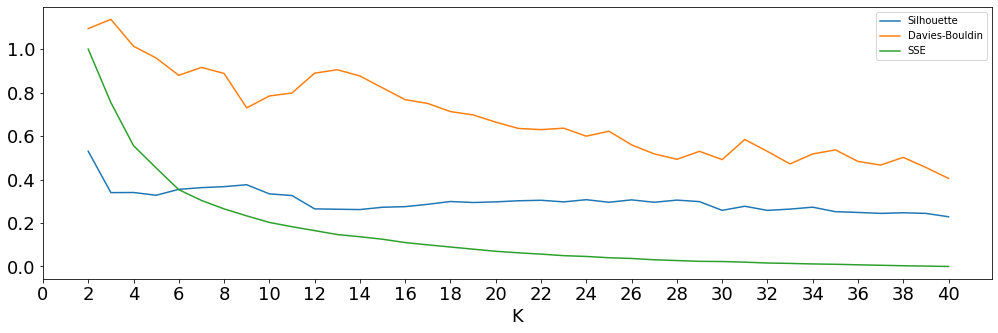

In [10]:
plot_metrics_per_k(X_w_out, ["sil", "db", "sse"], model_sk=KMeans(n_clusters=1, n_init=20, max_iter=100))

Current number of clusters: 4
Number of points per cluster label: {0: 49, 1: 8, 2: 20, 3: 1}
Number of singleton clusters: 1
Silhouette score: 0.34027625923798926


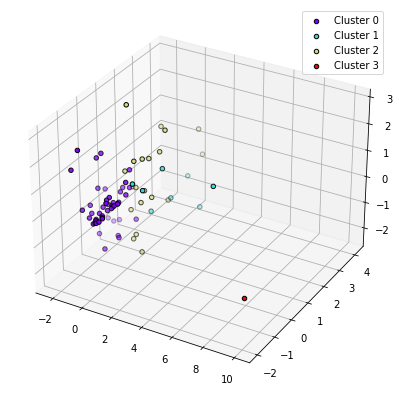

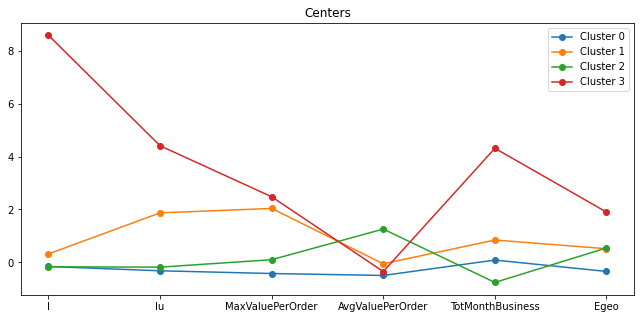

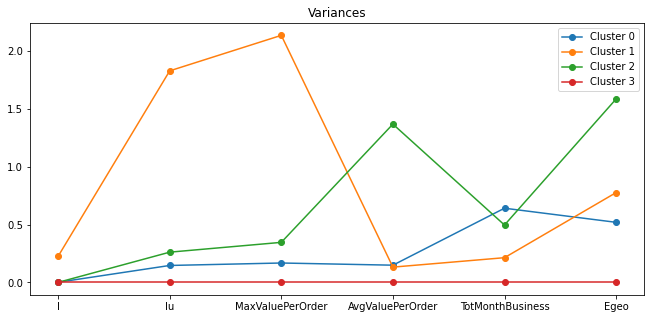

In [11]:
kmeans_w_out_clusters = 4
kmeans_w_out = KMeans(n_clusters=kmeans_w_out_clusters, n_init=20, max_iter=100).fit(X_w_out)

visualise_model_characteristics([X_w_out], [kmeans_w_out], [vendor_df_w_out_vis])

### K-means without outliers

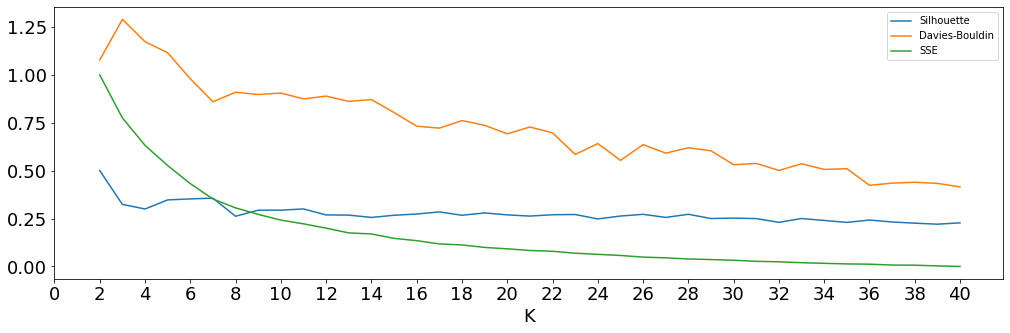

In [12]:
plot_metrics_per_k(X_wo_out, ["sil", "db", "sse"], model_sk=KMeans(n_clusters=1, n_init=20, max_iter=100))

Current number of clusters: 6
Number of points per cluster label: {0: 36, 1: 1, 2: 8, 3: 12, 4: 10, 5: 6}
Number of singleton clusters: 1
Silhouette score: 0.3534882696945238


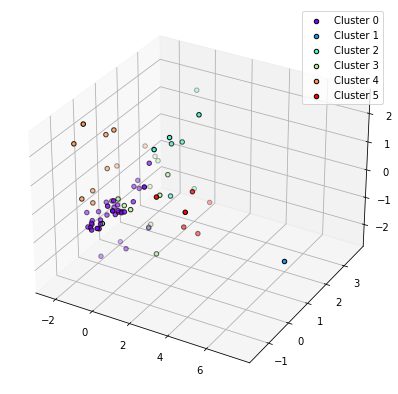

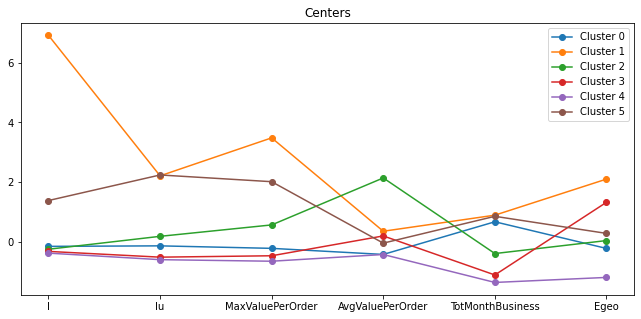

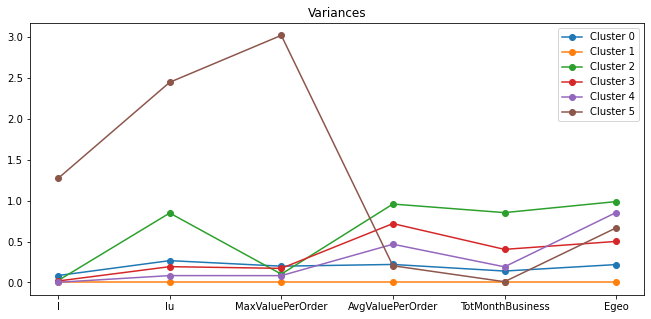

In [80]:
kmeans_wo_out_clusters = 6
kmeans_wo_out = KMeans(n_clusters=kmeans_wo_out_clusters, n_init=10, max_iter=100).fit(X_wo_out)

visualise_model_characteristics([X_wo_out], [kmeans_wo_out], [vendor_df_wo_out_vis])

### K-means without outliers (PCA)

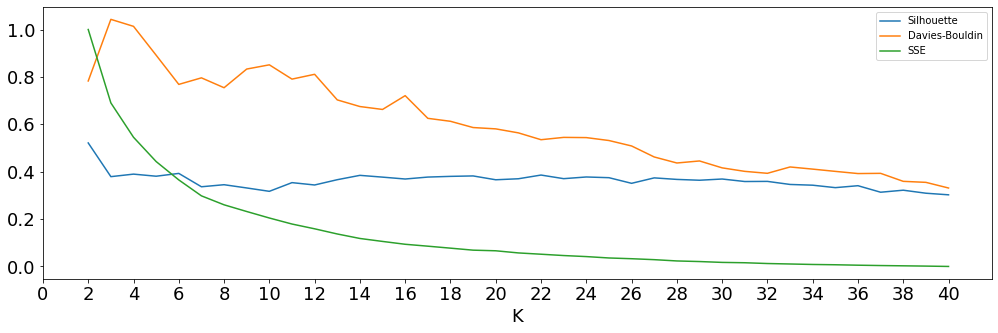

In [14]:
plot_metrics_per_k(X_pca_wo_out, ["sil", "db", "sse"], model_sk=KMeans(n_clusters=1, n_init=20, max_iter=100))

Current number of clusters: 5
Number of points per cluster label: {0: 7, 1: 37, 2: 13, 3: 8, 4: 8}
Number of singleton clusters: 0
Silhouette score: 0.3454590170436541


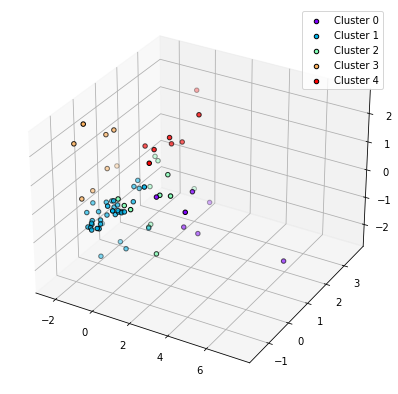

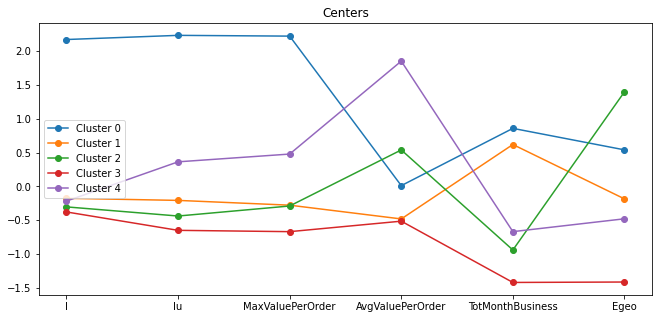

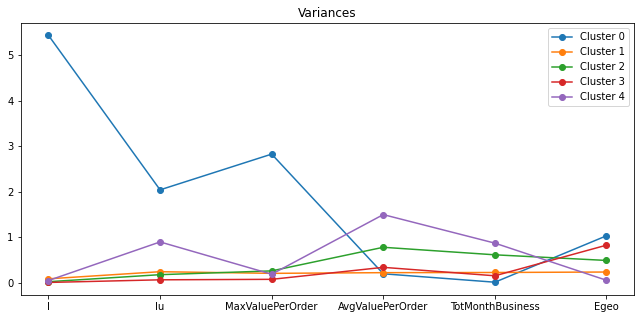

In [15]:
kmeans_w_out_pca_clusters = 5
kmeans_w_out_pca = KMeans(n_clusters=kmeans_w_out_pca_clusters, n_init=10, max_iter=100).fit(X_pca_wo_out)
visualise_model_characteristics([X_wo_out], [kmeans_w_out_pca], [vendor_df_wo_out_vis])

### K-means with outliers (Ward, initialisation only)

Current number of clusters: 4
Number of points per cluster label: {0: 22, 1: 47, 2: 1, 3: 8}
Number of singleton clusters: 1
Silhouette score: 0.3263441796908576


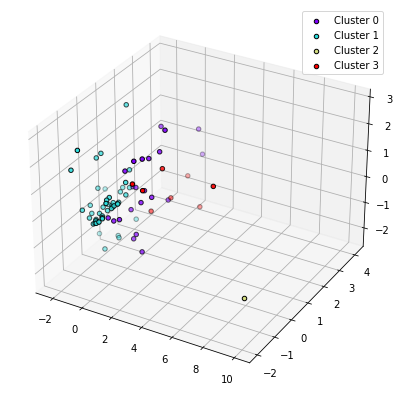

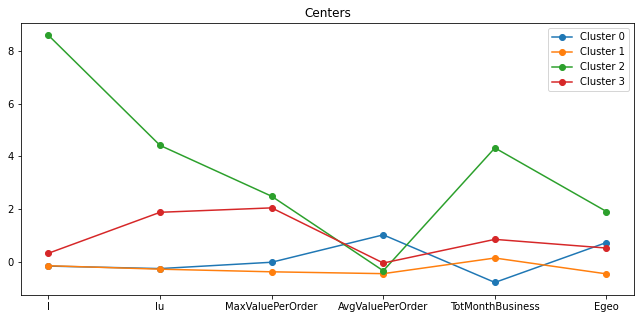

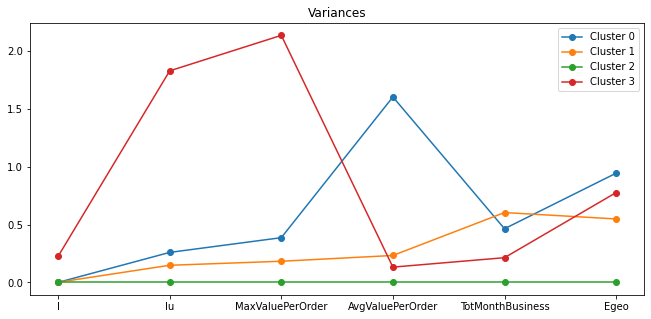

In [16]:
ward_clustering_w_out = AgglomerativeClustering(compute_distances=True, n_clusters=kmeans_w_out_clusters, linkage="ward").fit(X_w_out)
clust_mean_w_out = compute_cluster_means(X_w_out, ward_clustering_w_out.labels_)
kmeans_w_out_ward = KMeans(n_clusters=kmeans_w_out_clusters, init=clust_mean_w_out, n_init=1).fit(X_w_out)

visualise_model_characteristics([X_w_out], [kmeans_w_out_ward], [vendor_df_w_out_vis])

### K-means without outliers (Ward, initialisation only)

Current number of clusters: 7
Number of points per cluster label: {0: 7, 1: 6, 2: 15, 3: 17, 4: 12, 5: 10, 6: 6}
Number of singleton clusters: 0
Silhouette score: 0.21171486082410923


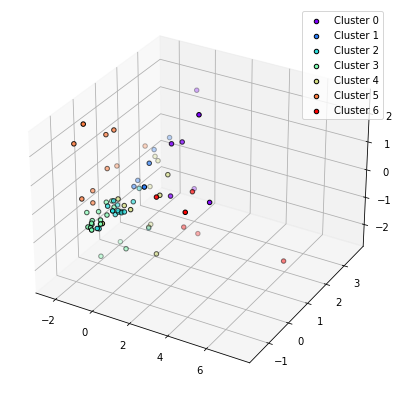

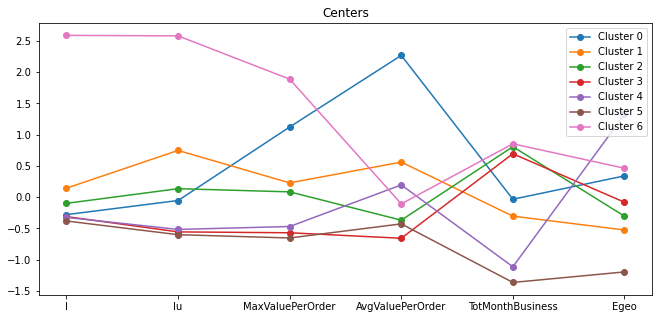

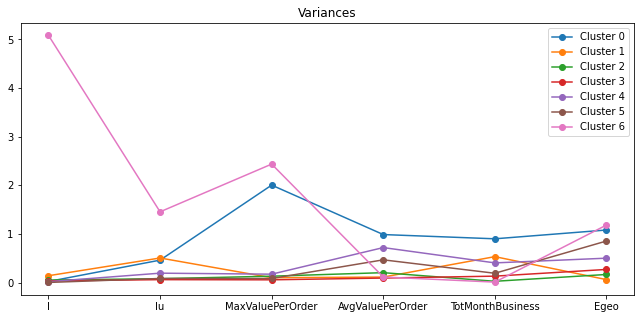

In [17]:
ward_clustering_wo_out = AgglomerativeClustering(compute_distances=True, n_clusters=kmeans_wo_out_clusters, linkage="ward").fit(X_w_out)
clust_mean_wo_out = compute_cluster_means(X_wo_out, ward_clustering_wo_out.labels_)
kmeans_wo_out_ward = KMeans(n_clusters=kmeans_wo_out_clusters, init=clust_mean_wo_out, n_init=1).fit(X_wo_out)

visualise_model_characteristics([X_wo_out], [kmeans_wo_out_ward], [vendor_df_wo_out_vis])

### X-means methodology  
Where X-means results, starting from a single cluster, were not satisfactory we increased the number of starting points until a good result was reached.  
The goodness of the result was measured through the use of the plotted metrics and the 3d visualisation.

### X-means with outliers

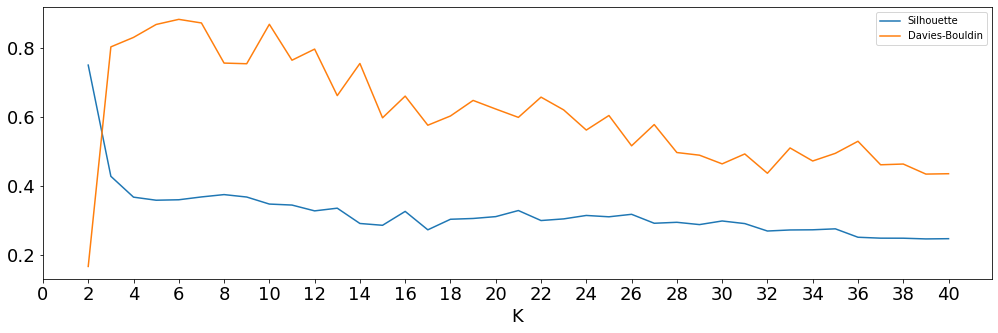

In [18]:
plot_metrics_per_k(X_w_out, ["sil", "db"], model_sk=xmeans_sk(n_clusters=1, n_init=10))

Current number of clusters: 6
Number of points per cluster label: {0: 8, 1: 39, 2: 7, 3: 8, 4: 1, 5: 15}
Number of singleton clusters: 1
Silhouette score: 0.3567167699938834


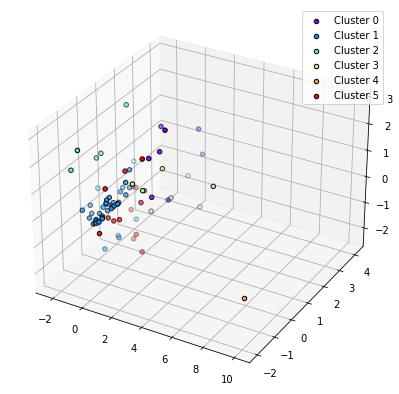

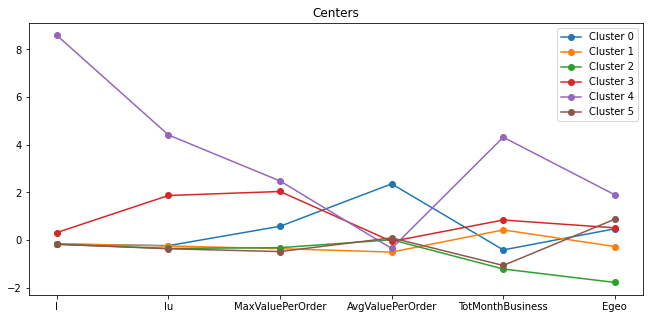

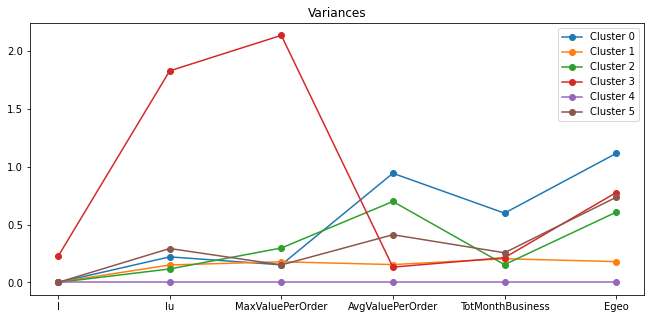

In [85]:
xmeans_w_out = xmeans_sk(n_clusters=5, n_init=20).fit(X_w_out)

visualise_model_characteristics([X_w_out], [xmeans_w_out], [vendor_df_w_out_vis])

### X-means without outliers

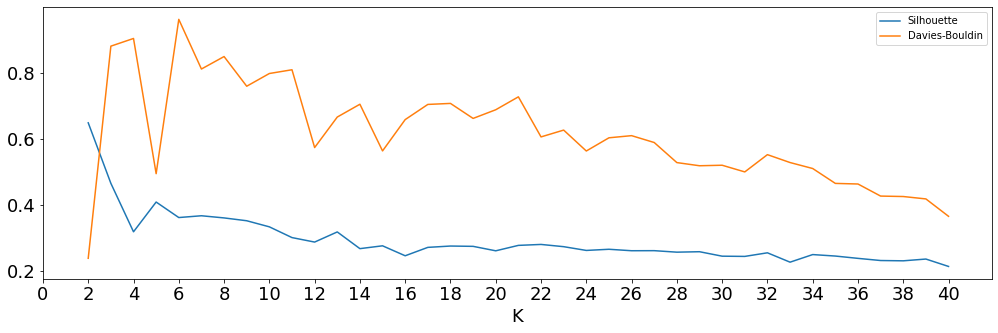

In [20]:
plot_metrics_per_k(X_wo_out, ["sil", "db"], model_sk=xmeans_sk(n_clusters=1, n_init=10))

Current number of clusters: 5
Number of points per cluster label: {0: 35, 1: 9, 2: 8, 3: 14, 4: 7}
Number of singleton clusters: 0
Silhouette score: 0.34826836716183984


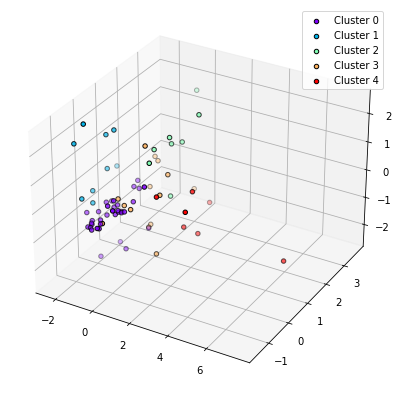

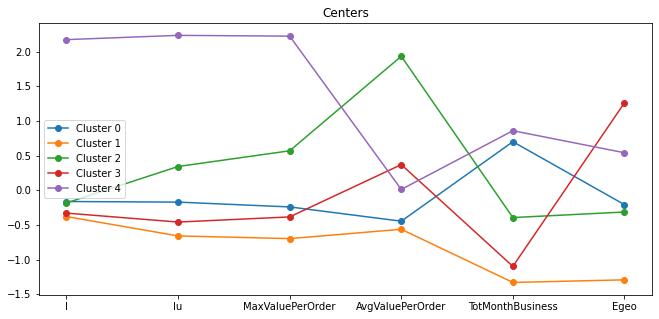

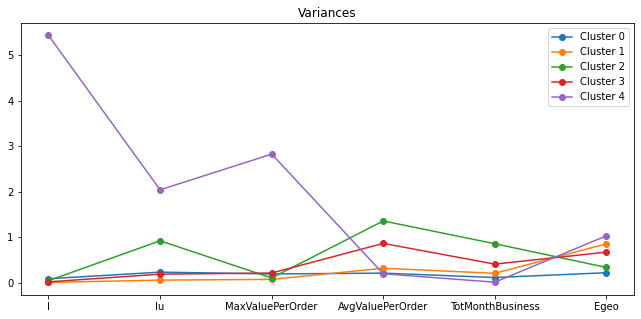

In [21]:
xmeans_wo_out = xmeans_sk(n_clusters=4, n_init=20).fit(X_wo_out)

visualise_model_characteristics([X_wo_out], [xmeans_wo_out], [vendor_df_wo_out_vis])

### X-means with outliers (Ward, initialisation only)

Current number of clusters: 6
Number of points per cluster label: {0: 8, 1: 9, 2: 10, 3: 36, 4: 14, 5: 1}
Number of singleton clusters: 1
Silhouette score: 0.34744310925533767


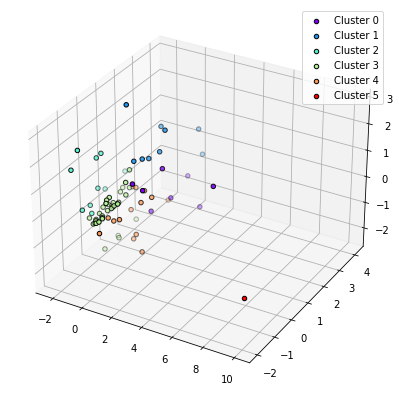

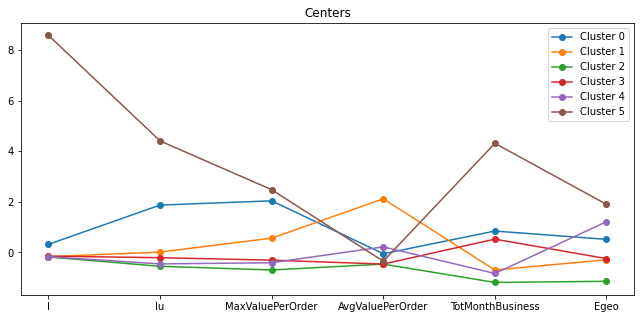

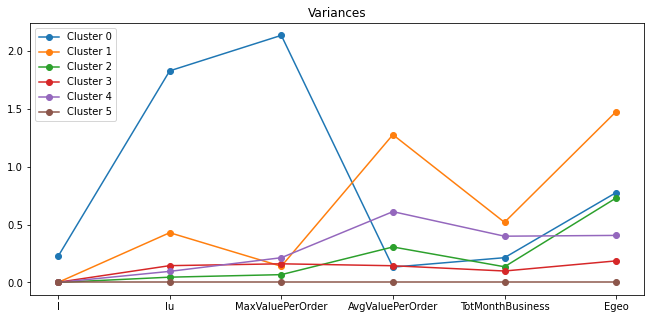

In [22]:
n_clusters = len(np.unique(xmeans_w_out.labels_))
ward_clustering_w_out = AgglomerativeClustering(compute_distances=True, n_clusters=n_clusters, linkage="ward").fit(X_w_out)
clust_mean_w_out = compute_cluster_means(X_w_out, ward_clustering_w_out.labels_)

xmeans_w_out_ward = xmeans_sk(n_clusters=n_clusters, init=clust_mean_w_out, n_init=30).fit(X_w_out)

visualise_model_characteristics([X_w_out], [xmeans_w_out_ward], [vendor_df_w_out_vis])

### X-means without outliers (Ward initialisation)

Current number of clusters: 5
Number of points per cluster label: {0: 6, 1: 15, 2: 17, 3: 34, 4: 1}
Number of singleton clusters: 1
Silhouette score: 0.30554128677091125


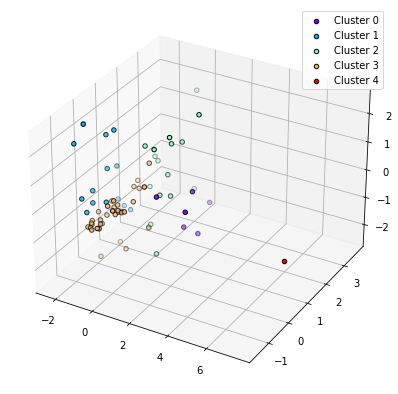

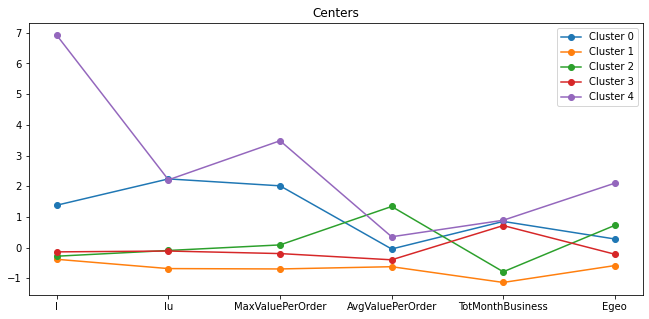

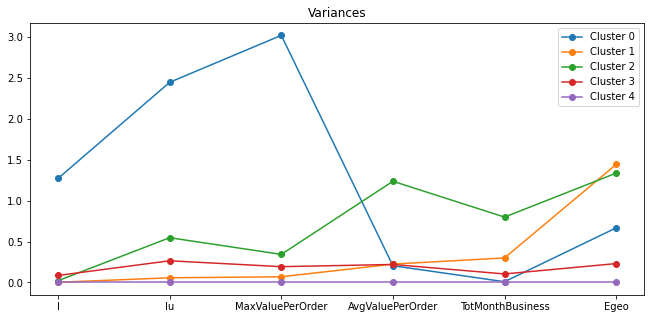

In [23]:
n_clusters = len(np.unique(xmeans_wo_out.labels_))
ward_clustering_wo_out = AgglomerativeClustering(compute_distances=True, n_clusters=n_clusters, linkage="ward").fit(X_wo_out)
clust_mean_wo_out = compute_cluster_means(X_wo_out, ward_clustering_wo_out.labels_)

xmeans_wo_out_ward = xmeans_sk(n_clusters=n_clusters, init=clust_mean_wo_out, n_init=30).fit(X_wo_out)

visualise_model_characteristics([X_wo_out], [xmeans_wo_out_ward], [vendor_df_wo_out_vis])

## Prototype-based evaluation

### K-Means

#### Non-Ward vs Ward

Current number of clusters: 4
Number of points per cluster label: {0: 49, 1: 8, 2: 20, 3: 1}
Number of singleton clusters: 1
Current number of clusters: 4
Number of points per cluster label: {0: 22, 1: 47, 2: 1, 3: 8}
Number of singleton clusters: 1
Silhouette score: 0.34027625923798926
Silhouette score: 0.3263441796908576


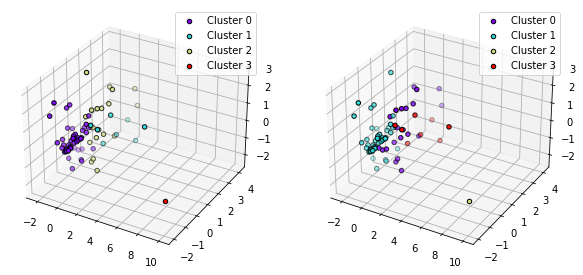

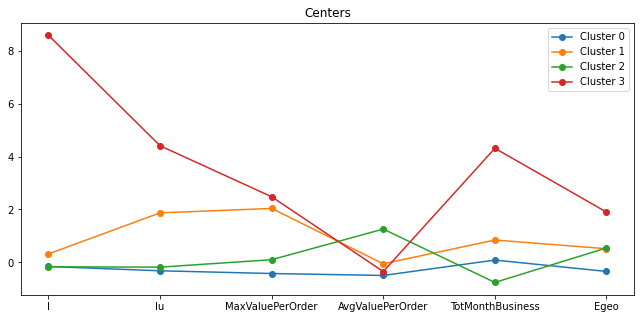

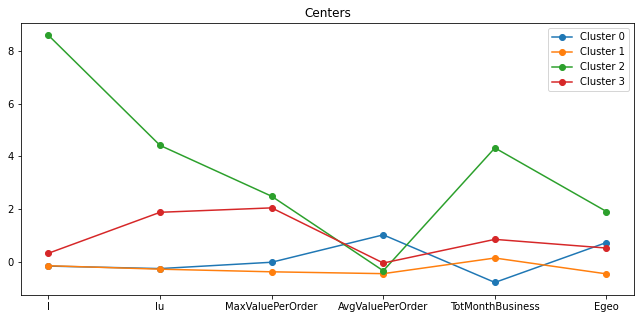

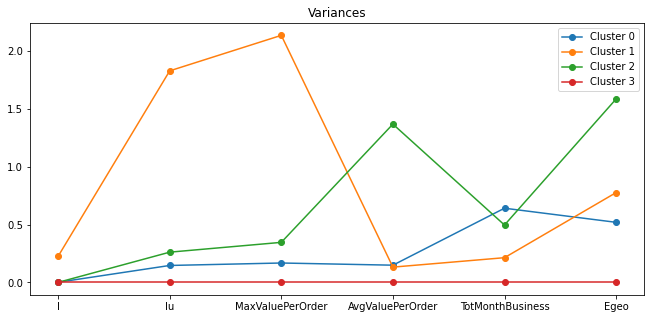

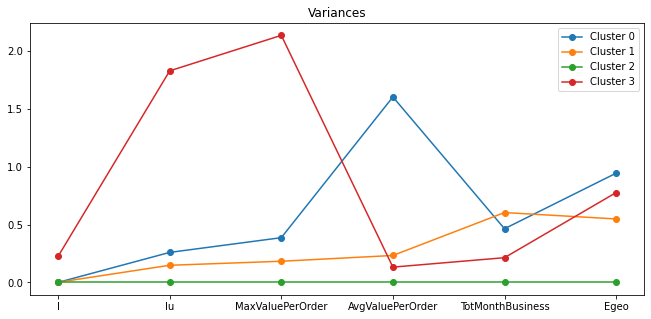

In [24]:
#With outliers
visualise_model_characteristics([X_w_out, X_w_out], [kmeans_w_out, kmeans_w_out_ward], [vendor_df_w_out_vis, vendor_df_w_out_vis])

Current number of clusters: 7
Number of points per cluster label: {0: 35, 1: 8, 2: 2, 3: 1, 4: 9, 5: 14, 6: 4}
Number of singleton clusters: 1
Current number of clusters: 7
Number of points per cluster label: {0: 7, 1: 6, 2: 15, 3: 17, 4: 12, 5: 10, 6: 6}
Number of singleton clusters: 0
Silhouette score: 0.3705096539129972
Silhouette score: 0.21171486082410923


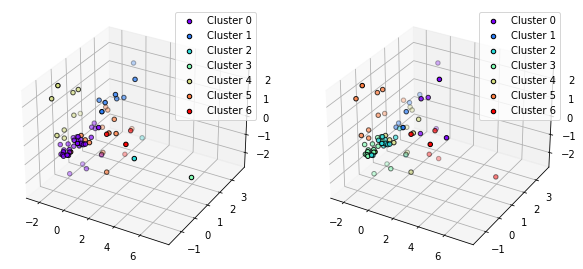

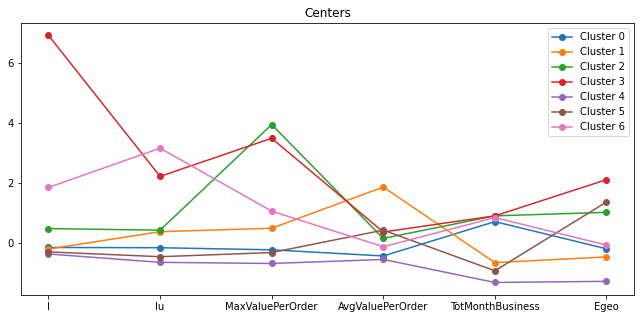

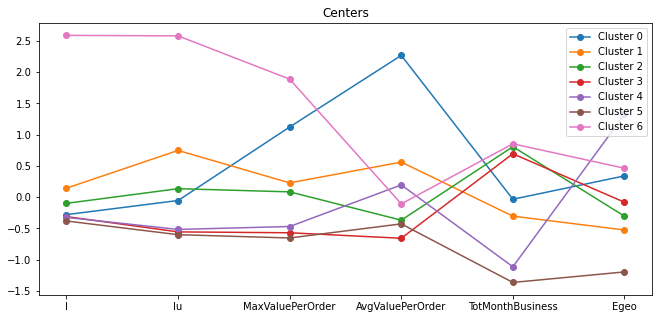

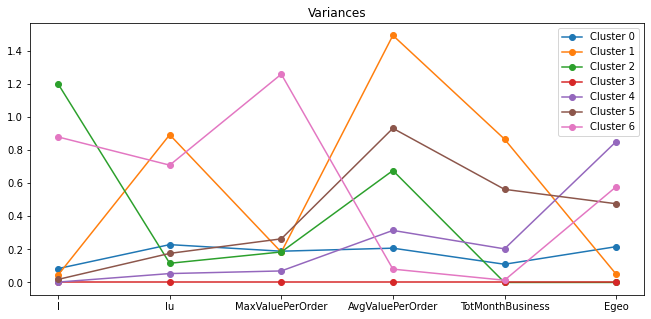

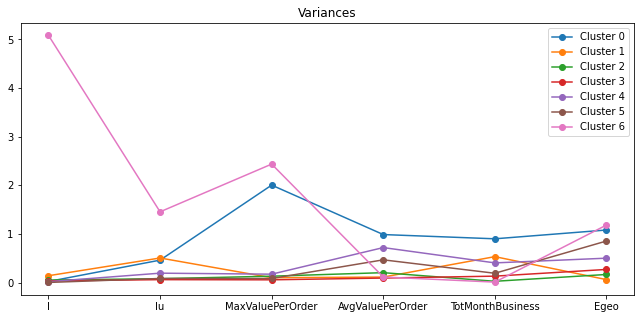

In [25]:
#Without outliers
visualise_model_characteristics([X_wo_out, X_wo_out], [kmeans_wo_out, kmeans_wo_out_ward], [vendor_df_wo_out_vis, vendor_df_wo_out_vis])

#### Conclusion  
The results were quite similar between the different versions, but the Ward version offers a better separation and a more stable result iteration after iteration.

### X-Means

#### Ward vs Non-Ward

Current number of clusters: 6
Number of points per cluster label: {0: 8, 1: 9, 2: 10, 3: 36, 4: 14, 5: 1}
Number of singleton clusters: 1
Current number of clusters: 6
Number of points per cluster label: {0: 8, 1: 9, 2: 10, 3: 36, 4: 14, 5: 1}
Number of singleton clusters: 1
Silhouette score: 0.34744310925533767
Silhouette score: 0.34744310925533767


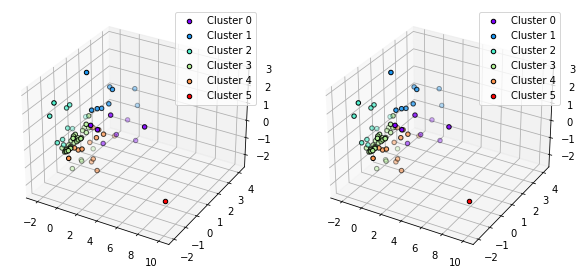

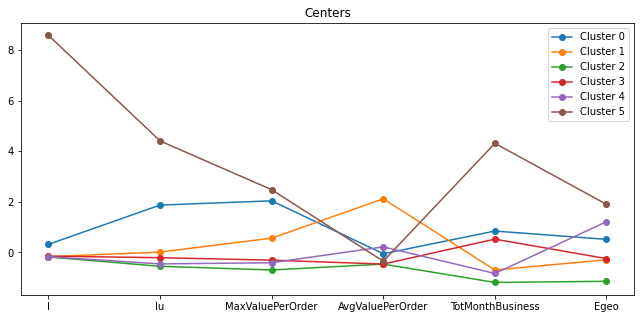

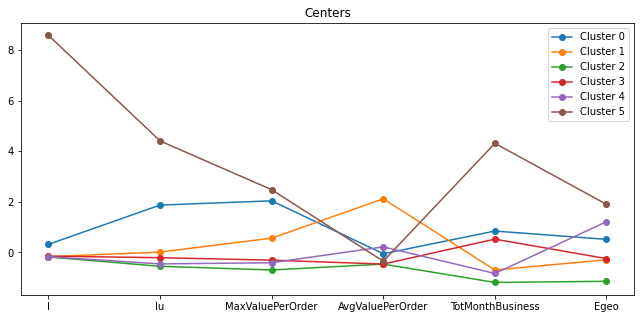

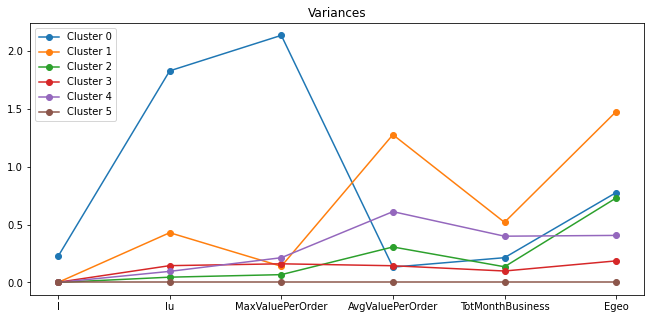

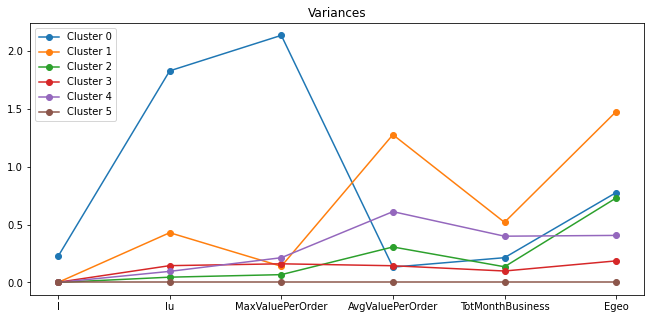

In [26]:
#With outliers
visualise_model_characteristics([X_w_out, X_w_out], [xmeans_w_out_ward, xmeans_w_out_ward], [vendor_df_w_out_vis, vendor_df_w_out_vis])

Current number of clusters: 5
Number of points per cluster label: {0: 35, 1: 9, 2: 8, 3: 14, 4: 7}
Number of singleton clusters: 0
Current number of clusters: 5
Number of points per cluster label: {0: 6, 1: 15, 2: 17, 3: 34, 4: 1}
Number of singleton clusters: 1
Silhouette score: 0.34826836716183984
Silhouette score: 0.30554128677091125


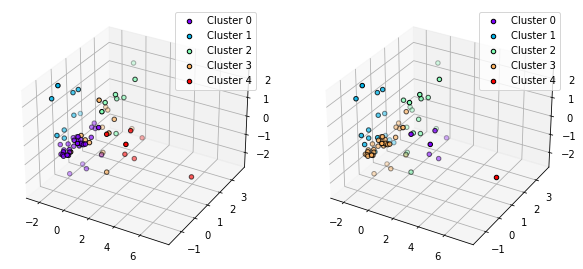

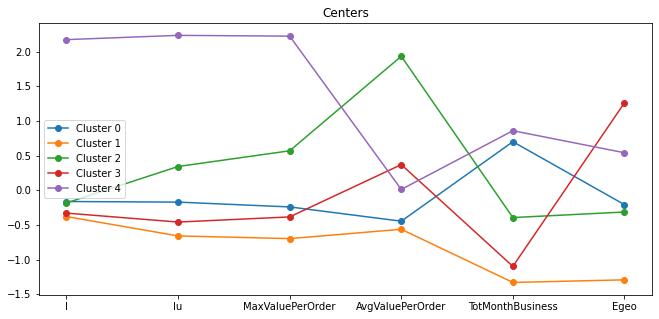

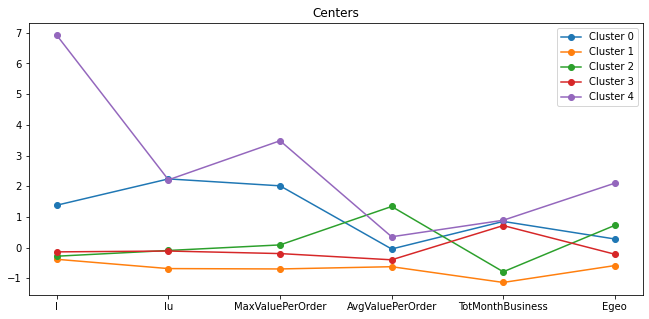

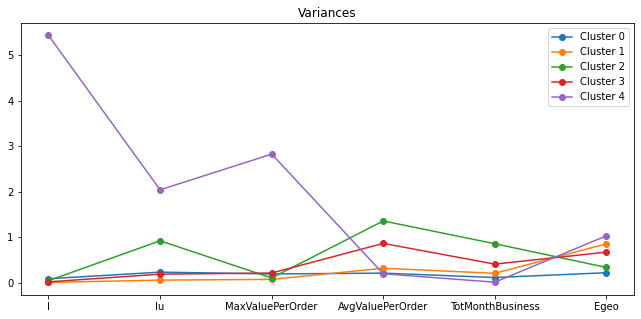

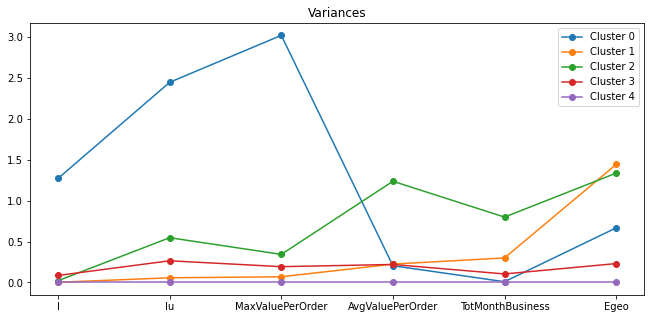

In [27]:
#Without outliers
visualise_model_characteristics([X_wo_out, X_wo_out], [xmeans_wo_out, xmeans_wo_out_ward], [vendor_df_wo_out_vis, vendor_df_wo_out_vis])

#### Conclusion

The results do not differ between the Ward and non-Ward versions, we will however prefer the Ward initialisation given the variance demonstrated by the X-means implementation during testing.

### K-means vs X-means

Current number of clusters: 4
Number of points per cluster label: {0: 22, 1: 47, 2: 1, 3: 8}
Number of singleton clusters: 1
Current number of clusters: 6
Number of points per cluster label: {0: 8, 1: 9, 2: 10, 3: 36, 4: 14, 5: 1}
Number of singleton clusters: 1
Silhouette score: 0.3263441796908576
Silhouette score: 0.34744310925533767


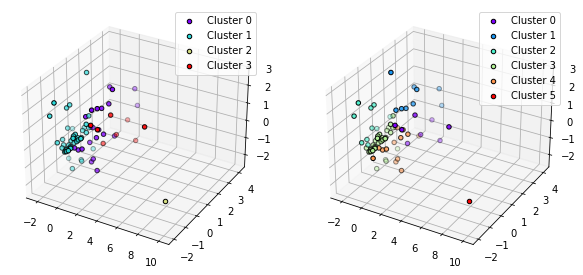

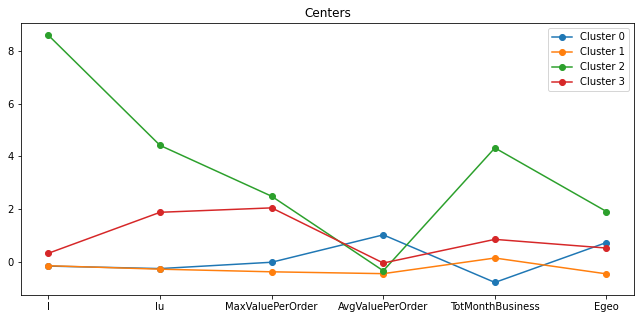

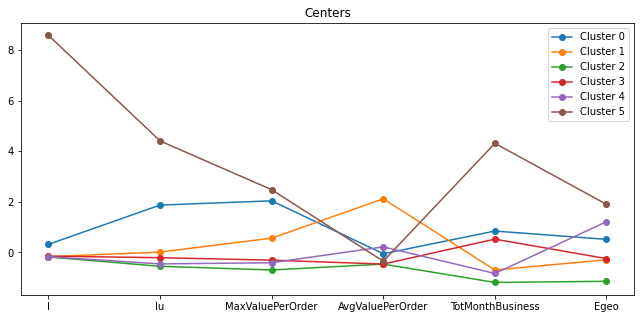

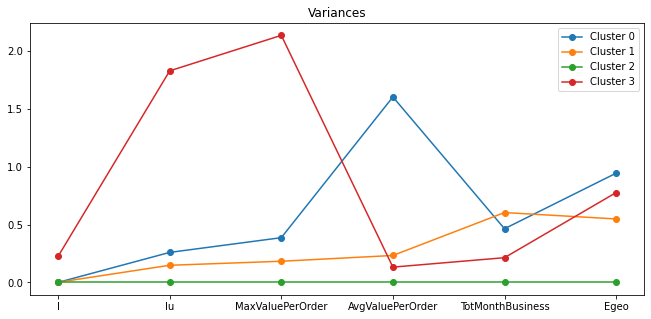

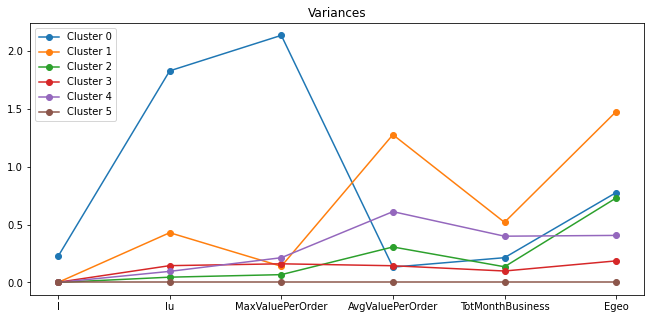

In [28]:
#With outliers
visualise_model_characteristics([X_w_out, X_w_out], [kmeans_w_out_ward, xmeans_w_out_ward], [vendor_df_w_out_vis, vendor_df_w_out_vis])

Current number of clusters: 7
Number of points per cluster label: {0: 7, 1: 6, 2: 15, 3: 17, 4: 12, 5: 10, 6: 6}
Number of singleton clusters: 0
Current number of clusters: 5
Number of points per cluster label: {0: 6, 1: 15, 2: 17, 3: 34, 4: 1}
Number of singleton clusters: 1
Silhouette score: 0.21171486082410923
Silhouette score: 0.30554128677091125


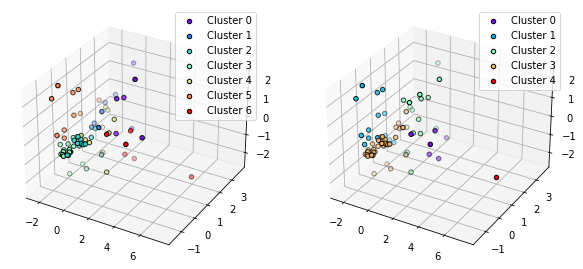

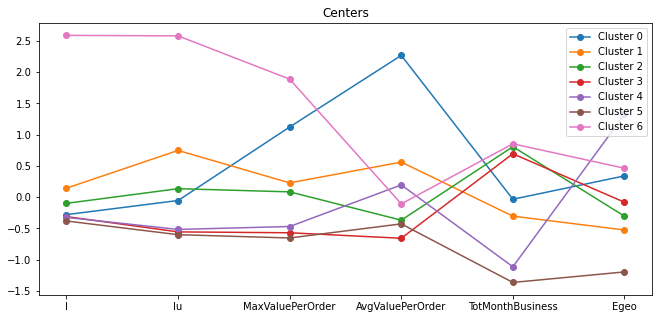

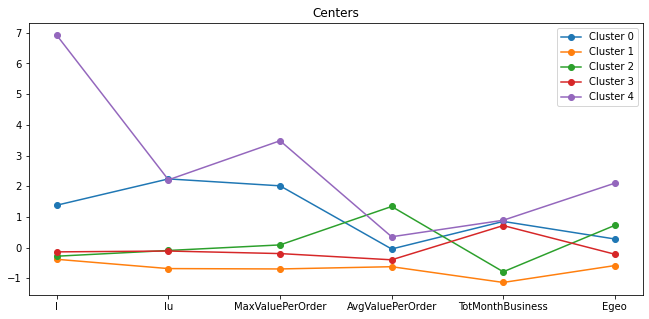

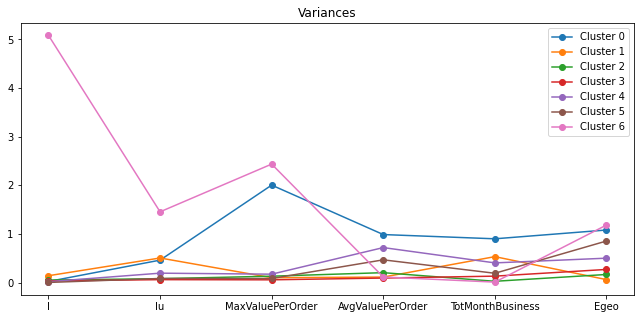

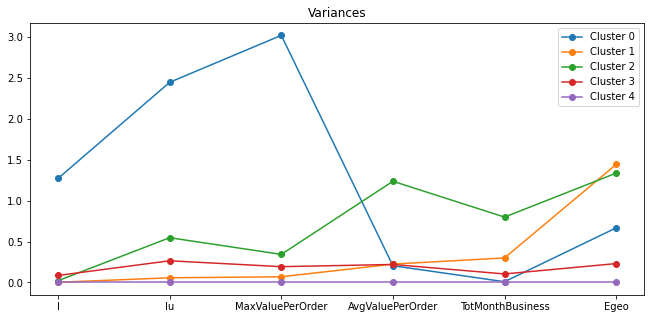

In [29]:
#Without outliers
visualise_model_characteristics([X_wo_out, X_wo_out], [kmeans_wo_out_ward, xmeans_wo_out_ward], [vendor_df_wo_out_vis, vendor_df_wo_out_vis])

#### Conclusion  
The differences in the clustering do not seem significant, since we preferred the Ward versions for both K-means and X-means this is to be expected.  
The obtained clustering seems reasonable visually considering the PCA plot and the scale of the axis, particularly in the versions without outliers since the axis altered significantly both in terms of direction and variance in the distribution of the points.  

In the situation with outliers the dominant feature in helping us identify the clusters is the line that splits the dataset in two.  
In the situation without outliers the line loses relevance since the points are more evenly distributed between the dimensions, we therefore looked for parameters that split the points in spatially distinct globular clusters keeping in mind the changes in the considered metrics.

There also seems to be no point in performing the analysis on the dataset after having applied PCA given that both prototype methods attempt to minimise the variance.

## Task 2.2: Density-based clustering

### Determine optimal eps and minSamples

In [30]:
#Nearest neighbour = 3
#plot_knn_dist([3, 3], [X_w_out, X_w_out])
#plot_knn_dist([3, 3], [X_pca_w_out, X_pca_wo_out])

The KNN distance plot didn't provide a clear solution, we therefore:  
-Tested out a number of min_samples to use and noticed that using reasonable values between 3 and 10 the results didn't change much and two seemed to find too many clusters in what otherwise we would consider noise.  
-Chose the eps parameter based on the chosen metrics values and then finetuned the results by hand exploring the 3d plot.

### DBSCAN with outliers

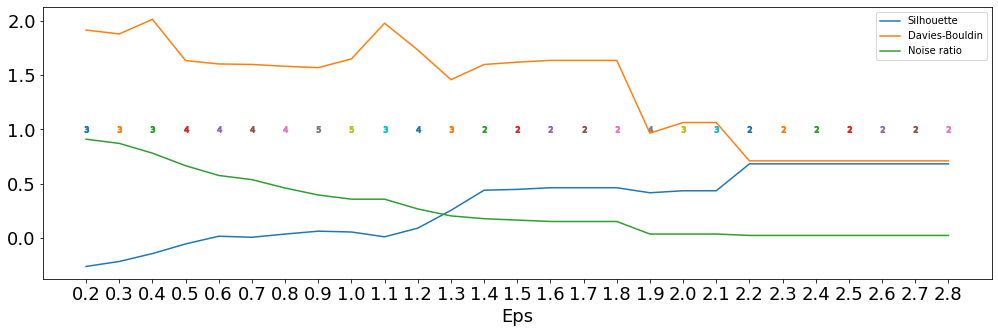

In [31]:
plot_metrics_per_eps(X_w_out, ["sil", "db", "noise_ratio", "clusters"], precision=0.1, model_sk=DBSCAN(min_samples = 3, eps = 1))

Current number of clusters: 4
Number of points per cluster label: {-1: 21, 0: 46, 1: 4, 2: 7}
Number of singleton clusters: 0
Silhouette score: 0.09219520416830115


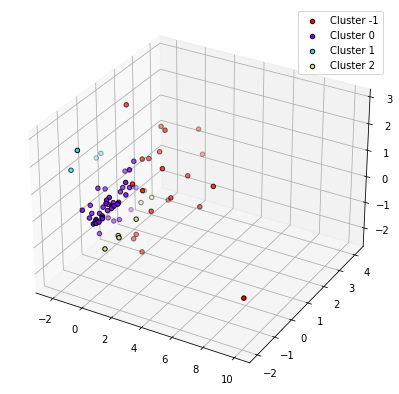

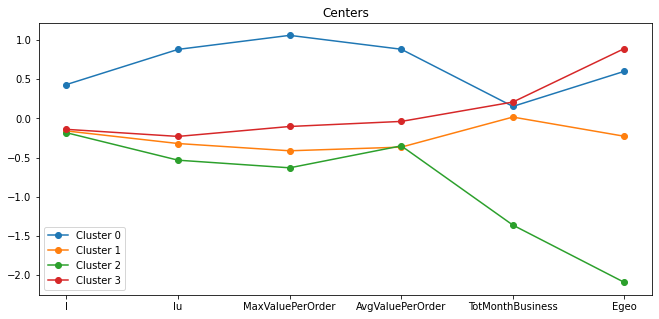

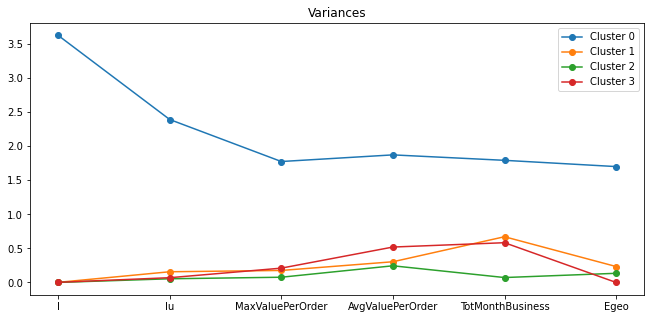

In [32]:
dbscan_w_out = DBSCAN(min_samples = 3, eps = 1.2).fit(X_w_out)
visualise_model_characteristics([X_w_out], [dbscan_w_out], [vendor_df_w_out_vis])

### DBSCAN without outliers

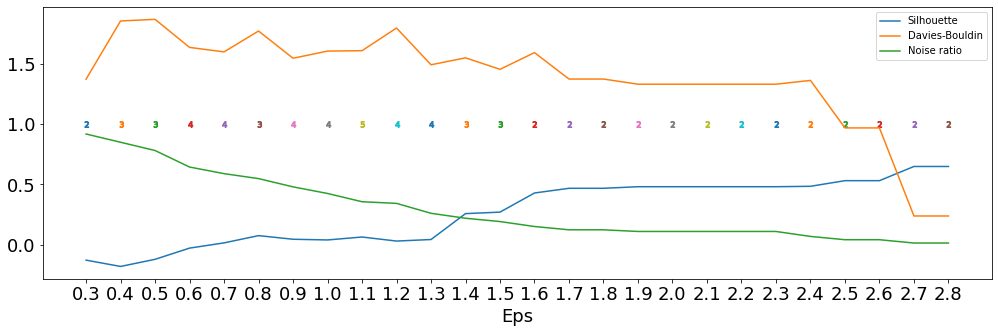

In [33]:
plot_metrics_per_eps(X_wo_out, ["sil", "db", "noise_ratio", "clusters"], precision=0.1, model_sk=DBSCAN(min_samples = 3, eps = 1))

Current number of clusters: 3
Number of points per cluster label: {-1: 14, 0: 55, 1: 4}
Number of singleton clusters: 0
Silhouette score: 0.26998194326408825


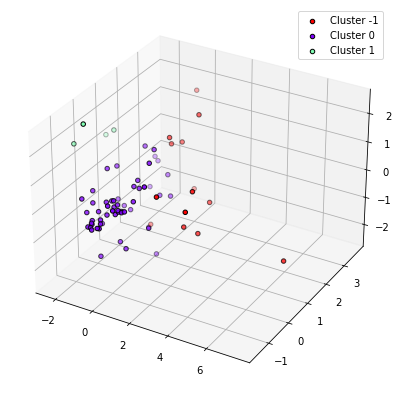

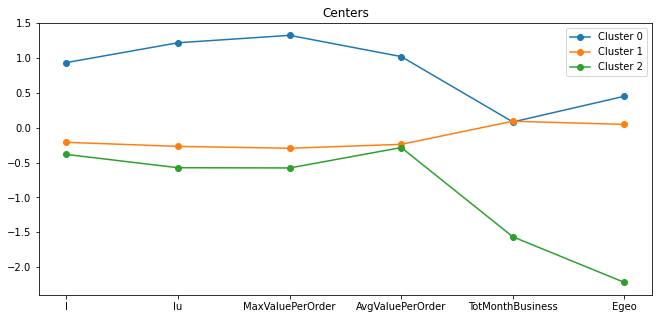

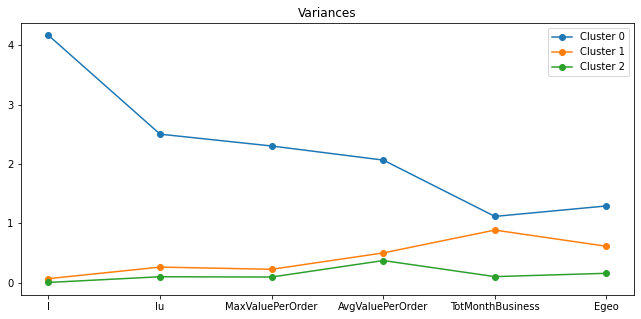

In [34]:
dbscan_wo_out = DBSCAN(min_samples = 3, eps = 1.5).fit(X_wo_out)
visualise_model_characteristics([X_wo_out], [dbscan_wo_out], [vendor_df_wo_out_vis])

### DBSCAN with outliers (PCA)

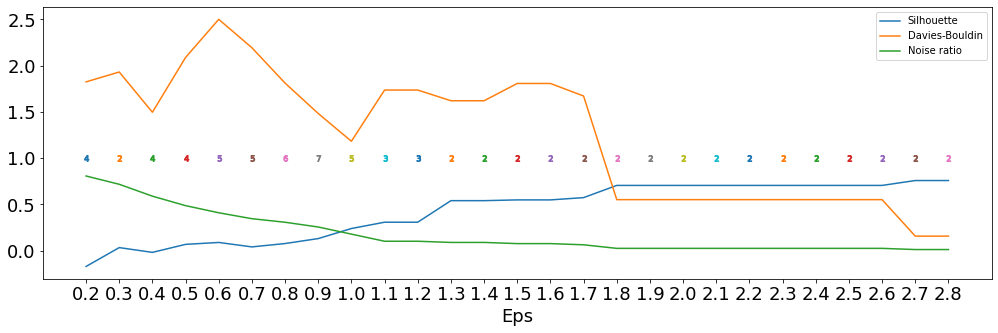

In [35]:
plot_metrics_per_eps(X_pca_w_out, ["sil", "db", "noise_ratio", "clusters"], precision=0.1, model_sk=DBSCAN(min_samples = 3, eps = 1))

Current number of clusters: 7
Number of points per cluster label: {-1: 20, 0: 41, 1: 4, 2: 3, 3: 3, 4: 4, 5: 3}
Number of singleton clusters: 0
Silhouette score: 0.06195973806596008


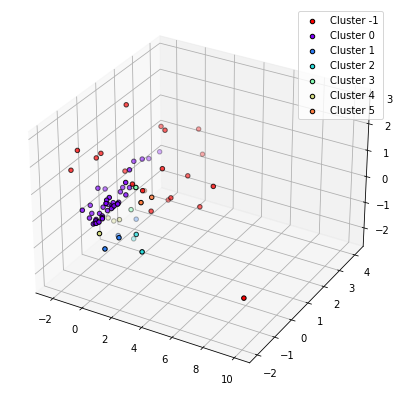

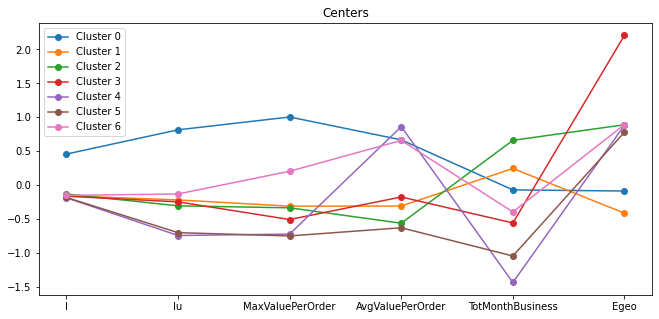

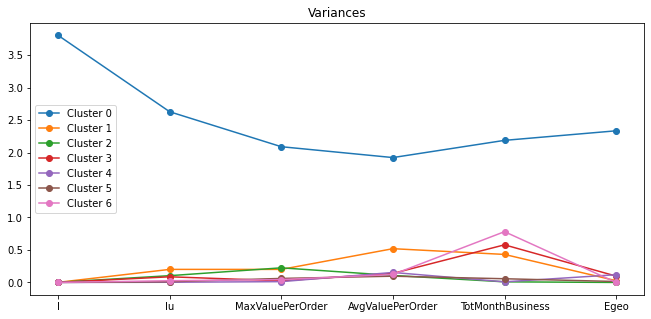

In [36]:
dbscan_w_out_pca = DBSCAN(min_samples = 3, eps = 0.9).fit(X_pca_w_out)
visualise_model_characteristics([X_w_out], [dbscan_w_out_pca], [vendor_df_w_out_vis])

### DBSCAN without outliers (PCA)

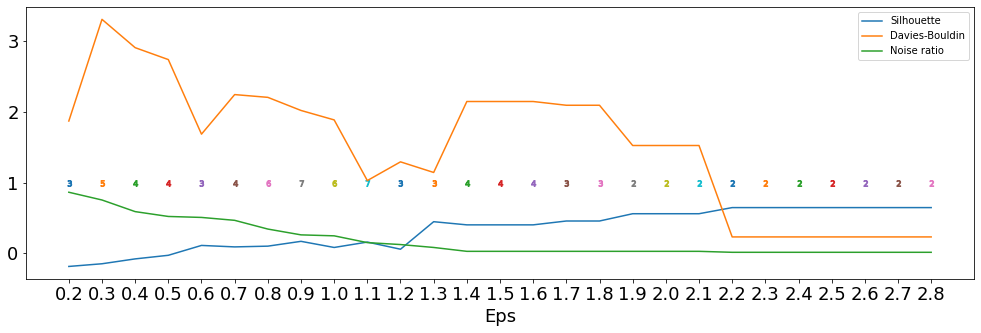

In [37]:
plot_metrics_per_eps(X_pca_wo_out, ["sil", "db", "noise_ratio", "clusters"], precision=0.1, model_sk=DBSCAN(min_samples = 3))

Current number of clusters: 4
Number of points per cluster label: {-1: 2, 0: 65, 1: 3, 2: 3}
Number of singleton clusters: 0
Silhouette score: 0.41257894462491285


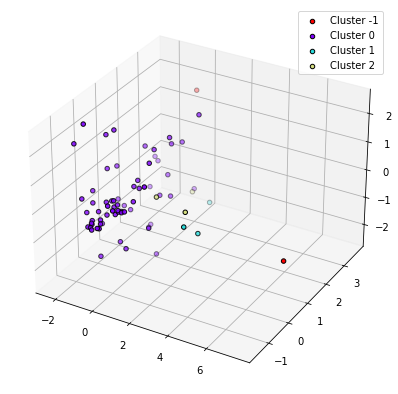

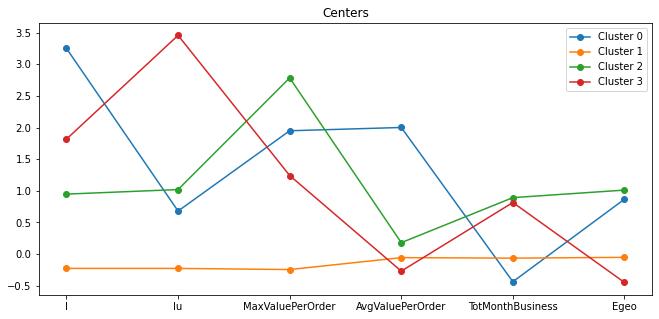

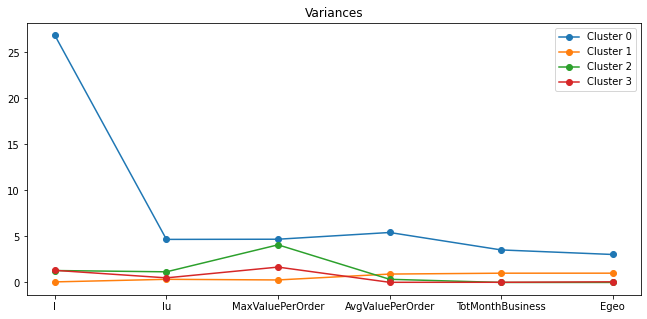

In [38]:
dbscan_wo_out_pca = DBSCAN(min_samples = 3, eps = 1.4).fit(X_pca_wo_out)
visualise_model_characteristics([X_wo_out], [dbscan_wo_out_pca], [vendor_df_wo_out_vis])

### DBSCAN evaluation  

#### Non-PCA vs PCA

Current number of clusters: 4
Number of points per cluster label: {-1: 21, 0: 46, 1: 4, 2: 7}
Number of singleton clusters: 0
Current number of clusters: 7
Number of points per cluster label: {-1: 20, 0: 41, 1: 4, 2: 3, 3: 3, 4: 4, 5: 3}
Number of singleton clusters: 0
Silhouette score: 0.09219520416830115
Silhouette score: 0.06195973806596008


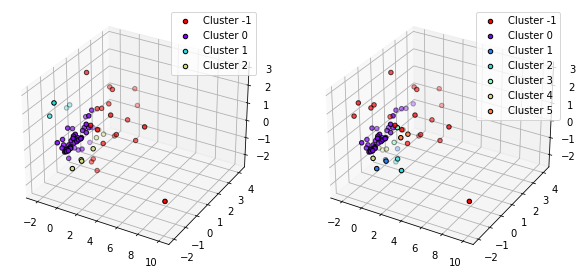

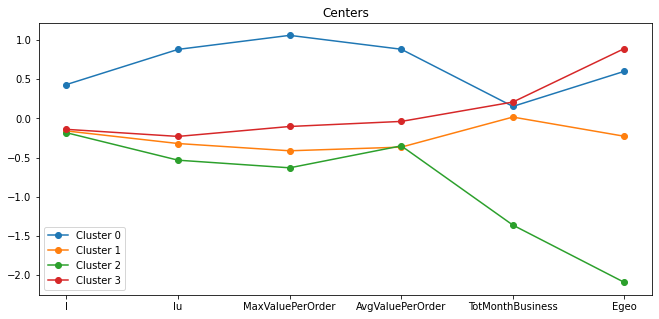

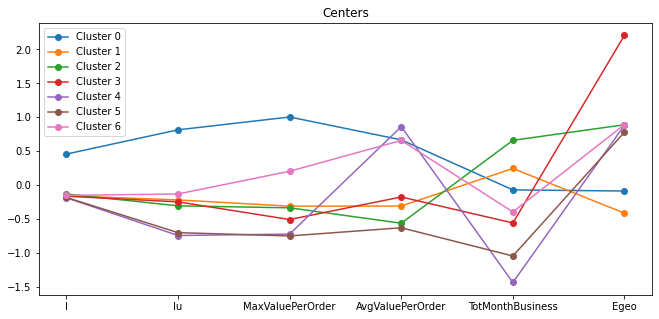

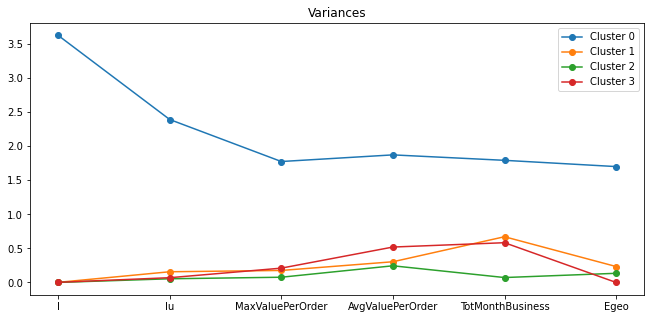

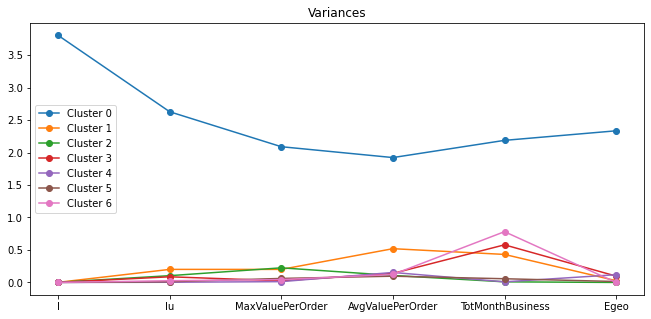

In [39]:
#With outliers
visualise_model_characteristics([X_w_out, X_w_out], [dbscan_w_out, dbscan_w_out_pca], [vendor_df_w_out_vis, vendor_df_w_out_vis])

Current number of clusters: 3
Number of points per cluster label: {-1: 14, 0: 55, 1: 4}
Number of singleton clusters: 0
Current number of clusters: 4
Number of points per cluster label: {-1: 2, 0: 65, 1: 3, 2: 3}
Number of singleton clusters: 0
Silhouette score: 0.26998194326408825
Silhouette score: 0.41257894462491285


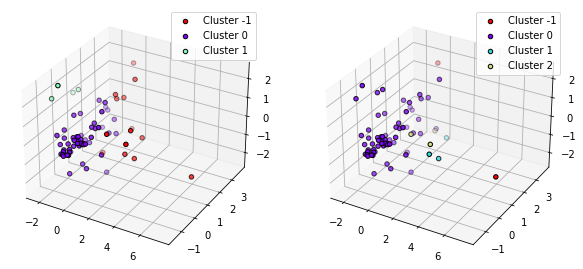

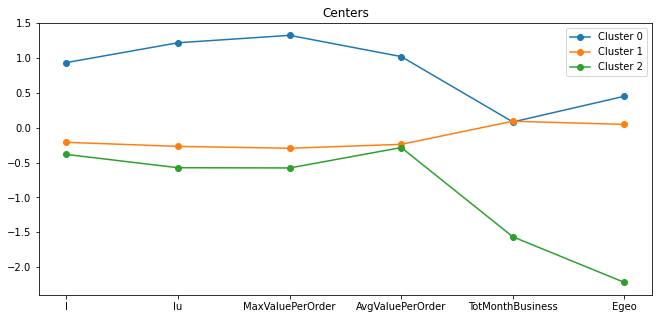

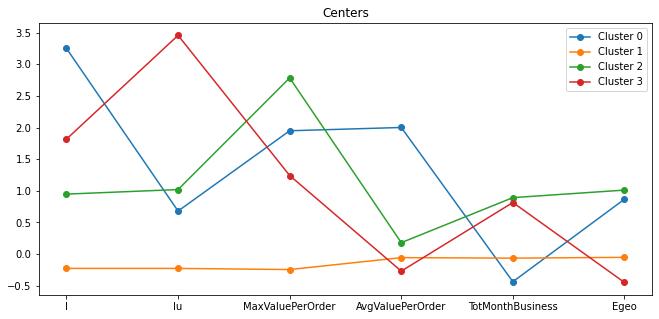

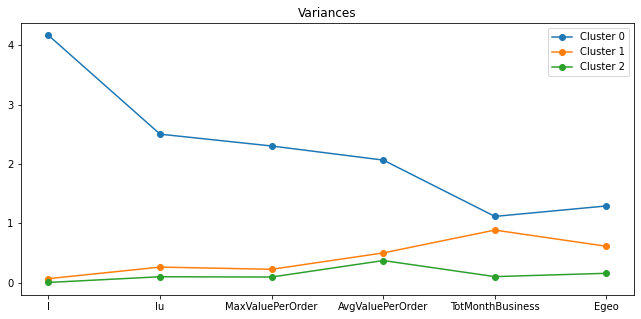

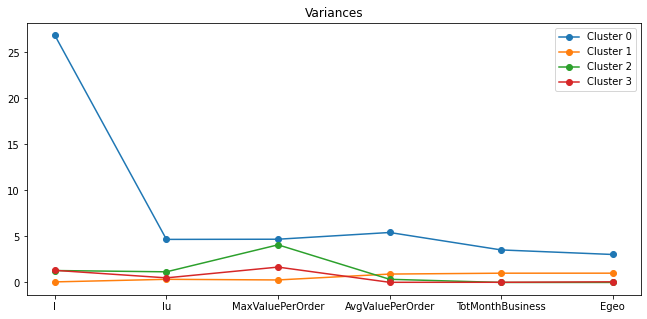

In [40]:
#Without outliers
visualise_model_characteristics([X_wo_out, X_wo_out], [dbscan_wo_out, dbscan_wo_out_pca], [vendor_df_wo_out_vis, vendor_df_wo_out_vis])

### Conclusion  
DBSCAN clusterings didn't discover any new pattern in the dataset, they however confirmed the clusterings obtained through the prototype-based methods although with a worse separation between the clusters.  
The weak performances of DBSCAN can be attributed to the different densities of the clusters.

## Task 2.3: Hierarchical clustering (Agglomerative)

### Single linkage with outliers

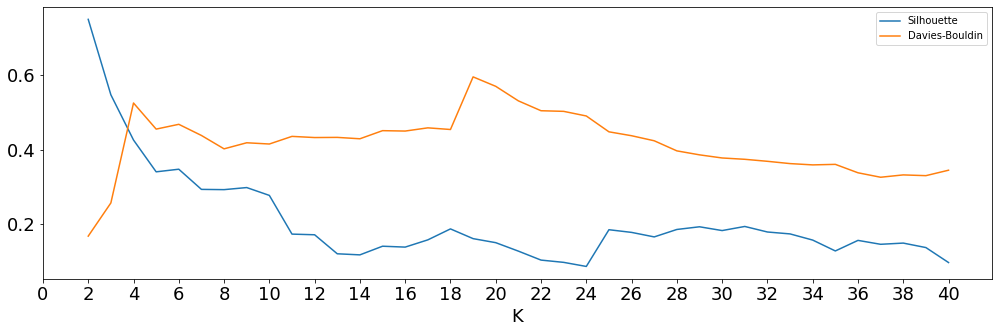

In [41]:
plot_metrics_per_k(X_w_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="single"))

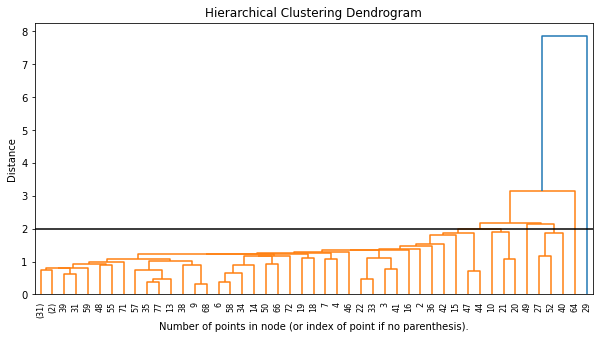

Current number of clusters: 5
Number of points per cluster label: {0: 72, 1: 3, 2: 1, 3: 1, 4: 1}
Number of singleton clusters: 3
Silhouette score: 0.33996317644790575


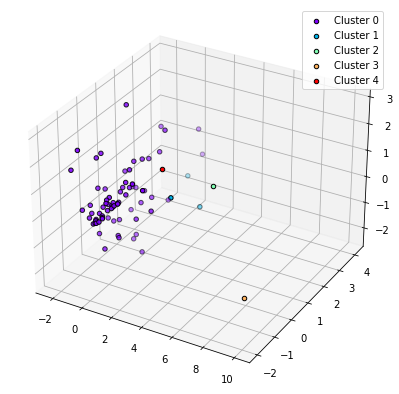

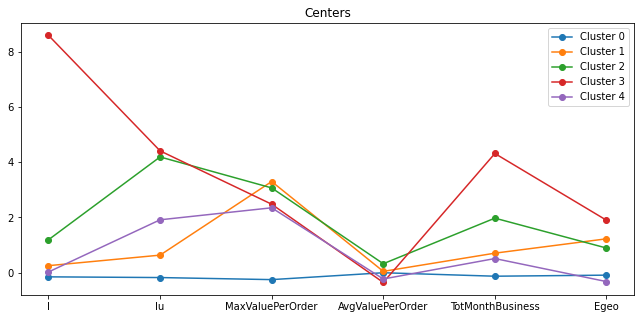

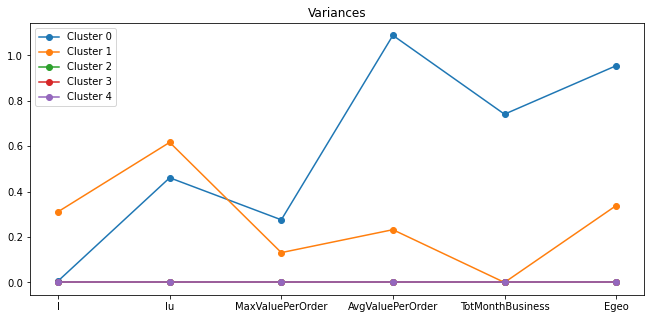

Cophenetic coefficient: 0.9181782484802548


In [42]:
max_d = 2#0.9

hier_clustering_single_w_out = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="single").fit(X_w_out)

plot_dendrogram(hier_clustering_single_w_out, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_w_out], [hier_clustering_single_w_out], [vendor_df_w_out_vis])

Z = linkage(X_w_out, 'single')
c, coph_dists = cophenet(Z, pdist(X_w_out))
print(f"Cophenetic coefficient: {c}")

### Single linkage without outliers

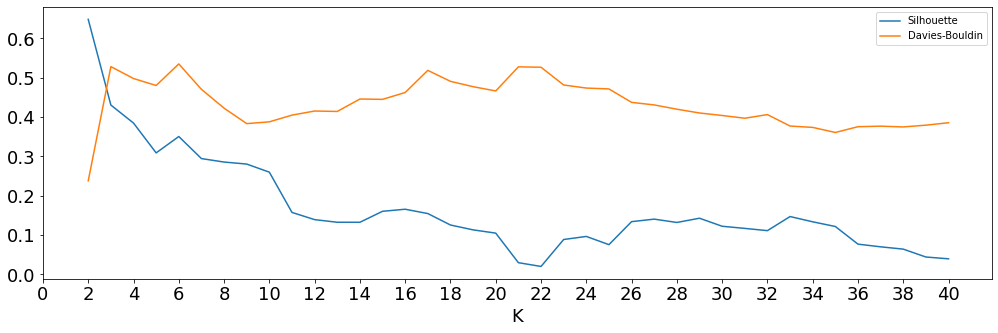

In [43]:
plot_metrics_per_k(X_wo_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="single"))

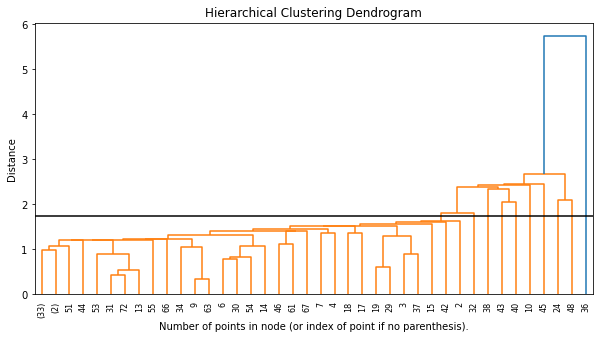

Current number of clusters: 10
Number of points per cluster label: {0: 64, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1}
Number of singleton clusters: 9
Silhouette score: 0.26005640670239966


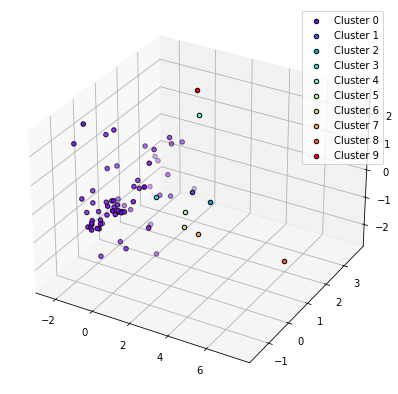

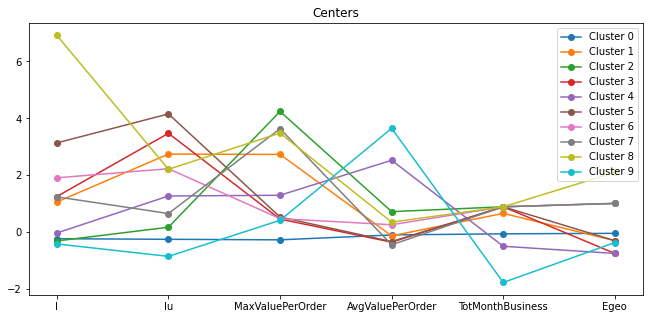

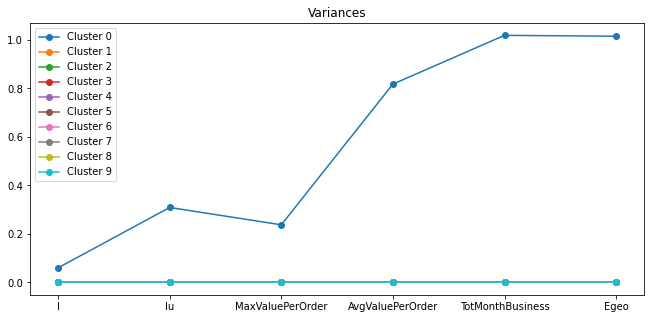

Cophenetic coefficient: 0.8768913486181625


In [44]:
max_d = 1.75

hier_clustering_single_wo_out = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="single").fit(X_wo_out)

plot_dendrogram(hier_clustering_single_wo_out, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_wo_out], [hier_clustering_single_wo_out], [vendor_df_wo_out_vis])

Z = linkage(X_wo_out, 'single')
c, coph_dists = cophenet(Z, pdist(X_wo_out))
print(f"Cophenetic coefficient: {c}")

### Single linkage with outliers (PCA)

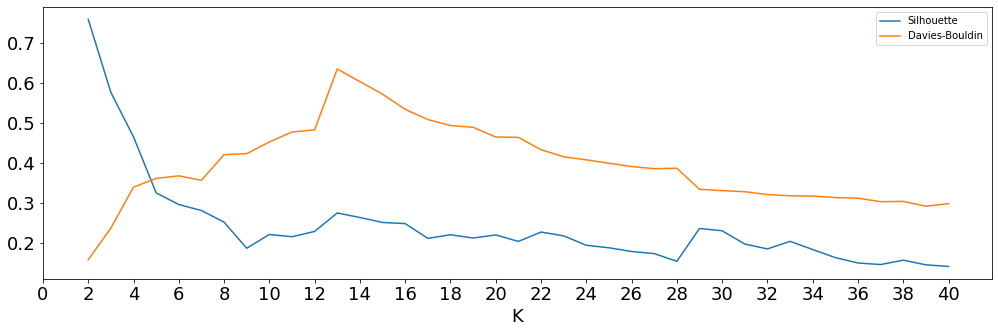

In [45]:
plot_metrics_per_k(X_pca_w_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="single"))

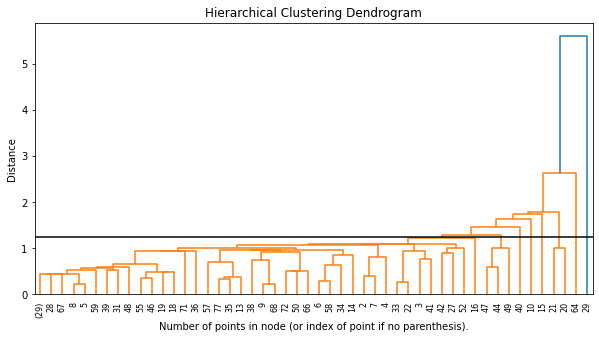

Current number of clusters: 8
Number of points per cluster label: {0: 68, 1: 3, 2: 1, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1}
Number of singleton clusters: 5
Silhouette score: 0.24444083474557937


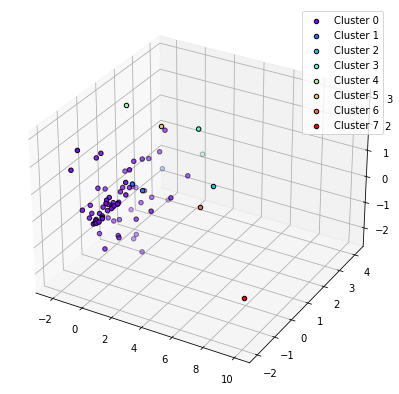

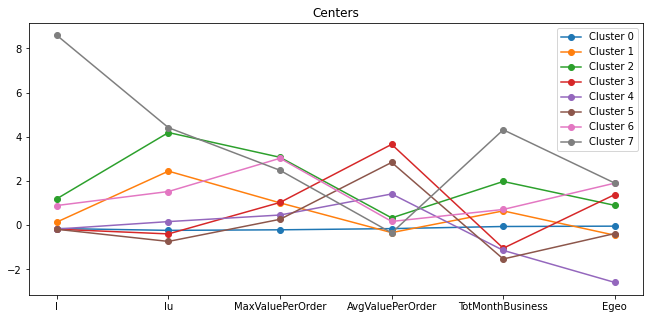

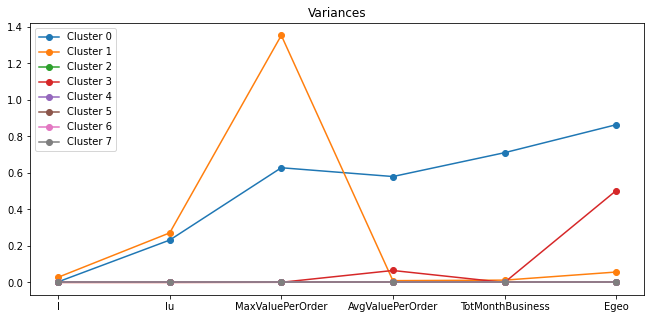

Cophenetic coefficient: 0.9181782484802548


In [46]:
max_d = 1.25#0.66

hier_clustering_single_w_out_pca = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="single").fit(X_pca_w_out)

plot_dendrogram(hier_clustering_single_w_out_pca, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_w_out], [hier_clustering_single_w_out_pca], [vendor_df_w_out_vis])

Z = linkage(X_w_out, 'single')
c, coph_dists = cophenet(Z, pdist(X_w_out))
print(f"Cophenetic coefficient: {c}")

### Single linkage without outliers (PCA)

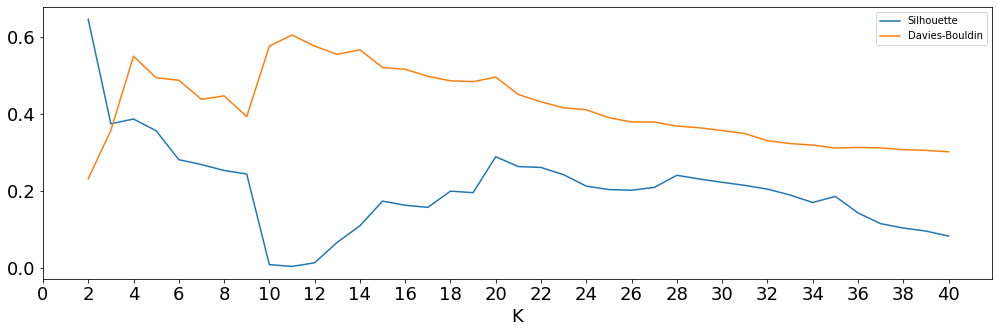

In [47]:
plot_metrics_per_k(X_pca_wo_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="single"))

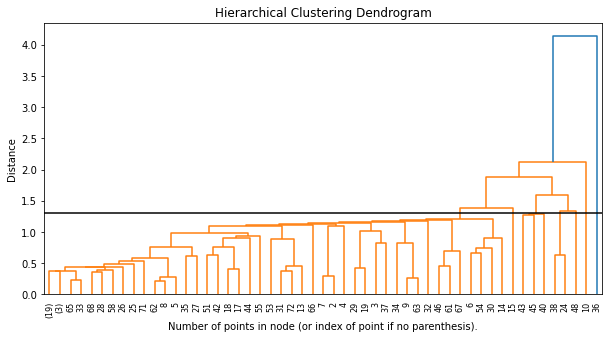

Current number of clusters: 7
Number of points per cluster label: {0: 3, 1: 1, 2: 64, 3: 1, 4: 1, 5: 1, 6: 2}
Number of singleton clusters: 4
Silhouette score: 0.22763391792735807


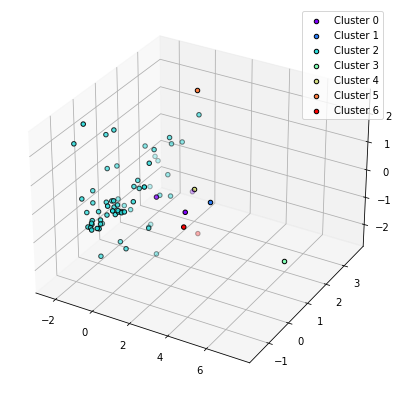

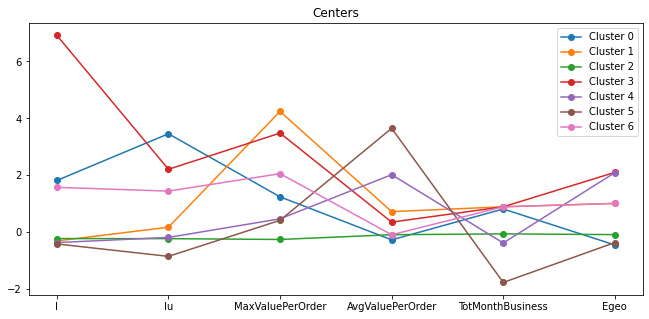

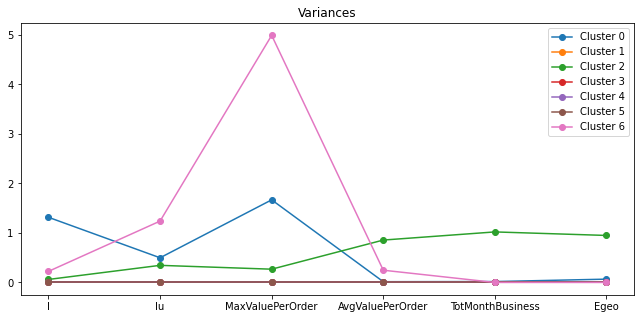

Cophenetic coefficient: 0.8768913486181625


In [48]:
max_d = 1.3#0.8

hier_clustering_single_wo_out_pca = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="single").fit(X_pca_wo_out)

plot_dendrogram(hier_clustering_single_wo_out_pca, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_wo_out], [hier_clustering_single_wo_out_pca], [vendor_df_wo_out_vis])

Z = linkage(X_wo_out, 'single')
c, coph_dists = cophenet(Z, pdist(X_wo_out))
print(f"Cophenetic coefficient: {c}")

### Conclusion  
The results for the single linkage are terrible, probably given the fact that the majority of the points are concentrated in a small space and the others get sparser the more distant from the center they are, with and without outliers.

### Complete linkage with outliers

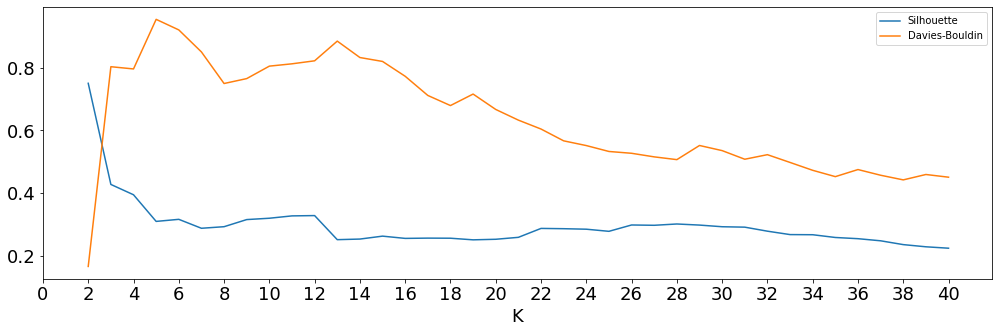

In [49]:
plot_metrics_per_k(X_w_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="complete"))

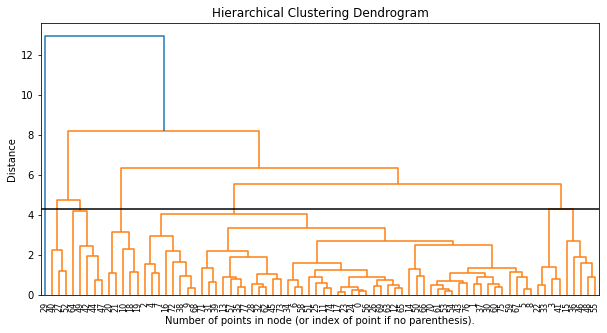

Current number of clusters: 6
Number of points per cluster label: {0: 9, 1: 55, 2: 5, 3: 1, 4: 5, 5: 3}
Number of singleton clusters: 1
Silhouette score: 0.3169630778404187


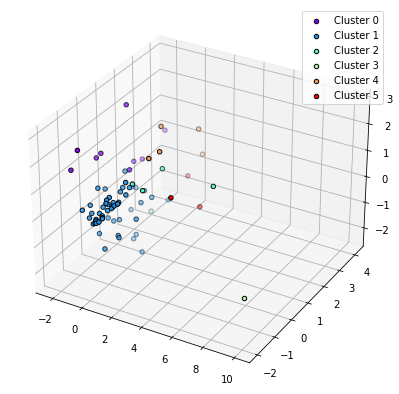

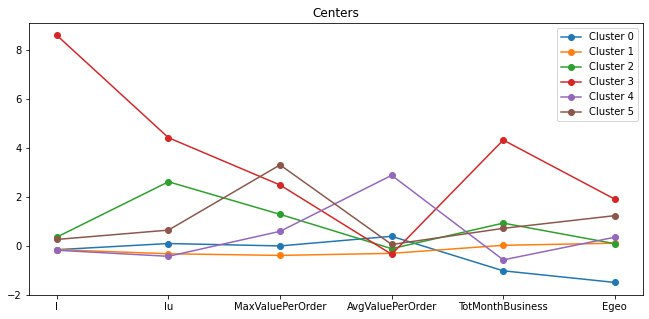

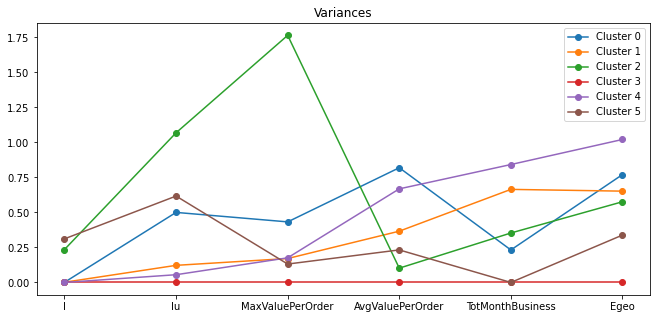

Cophenetic coefficient: 0.8382730976398546


In [50]:
max_d = 4.3

hier_clustering_complete_w_out = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="complete").fit(X_w_out)

plot_dendrogram(hier_clustering_complete_w_out, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_w_out], [hier_clustering_complete_w_out], [vendor_df_w_out_vis])

Z = linkage(X_w_out, 'complete')
c, coph_dists = cophenet(Z, pdist(X_w_out))
print(f"Cophenetic coefficient: {c}")

### Complete linkage without outliers

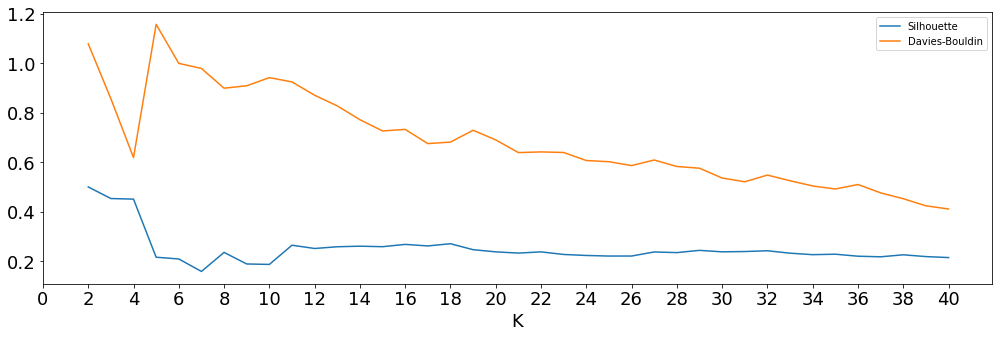

In [51]:
plot_metrics_per_k(X_wo_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="complete"))

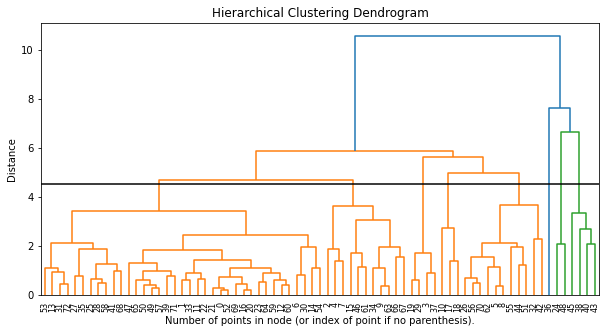

Current number of clusters: 8
Number of points per cluster label: {0: 11, 1: 11, 2: 3, 3: 37, 4: 4, 5: 1, 6: 4, 7: 2}
Number of singleton clusters: 1
Silhouette score: 0.23651119485274189


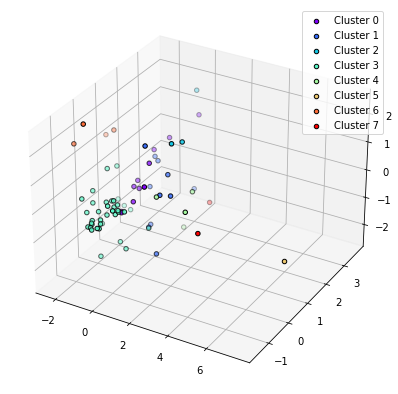

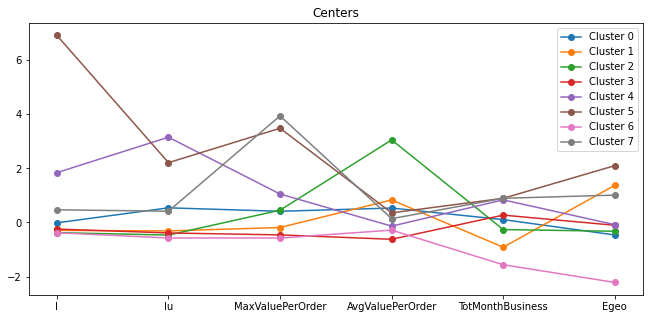

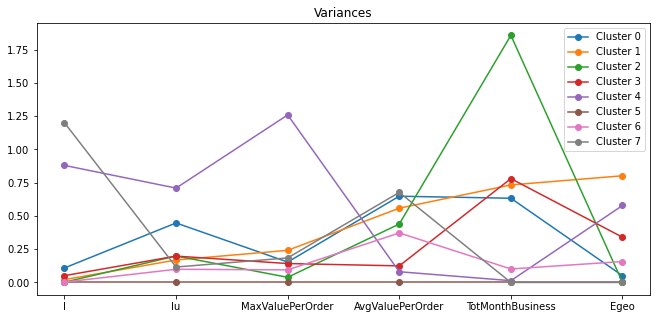

Cophenetic coefficient: 0.7712574928744994


In [52]:
max_d = 4.5#5.6

hier_clustering_complete_wo_out = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="complete").fit(X_wo_out)

plot_dendrogram(hier_clustering_complete_wo_out, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_wo_out], [hier_clustering_complete_wo_out], [vendor_df_wo_out_vis])

Z = linkage(X_wo_out, 'complete')
c, coph_dists = cophenet(Z, pdist(X_wo_out))
print(f"Cophenetic coefficient: {c}")

### Complete linkage with outliers (PCA)

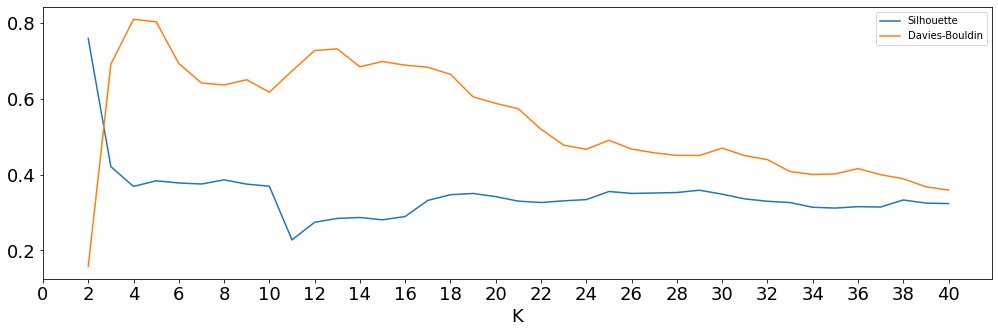

In [53]:
plot_metrics_per_k(X_pca_w_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="complete"))

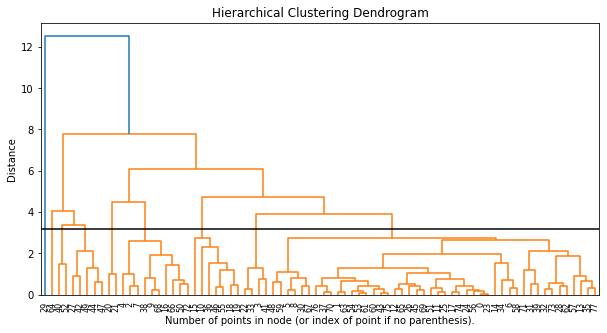

Current number of clusters: 9
Number of points per cluster label: {0: 7, 1: 46, 2: 10, 3: 2, 4: 5, 5: 2, 6: 1, 7: 1, 8: 4}
Number of singleton clusters: 2
Silhouette score: 0.324878676126374


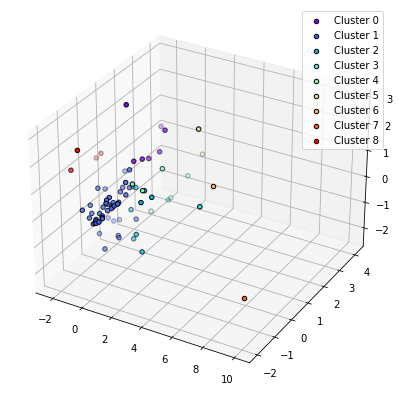

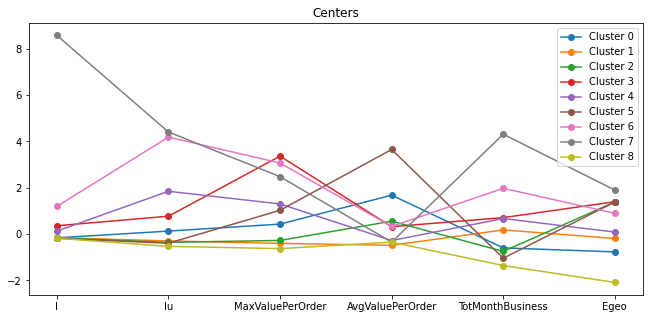

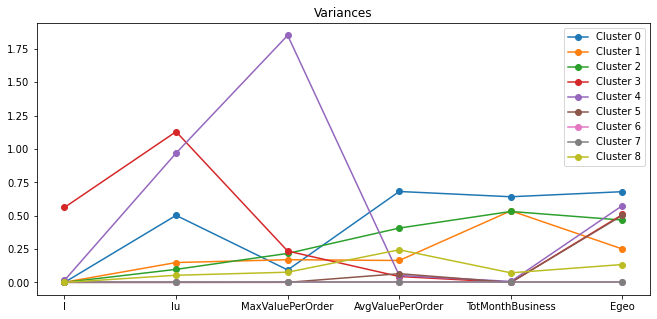

Cophenetic coefficient: 0.8382730976398546


In [54]:
max_d = 3.2#1.9

hier_clustering_complete_w_out_pca = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="complete").fit(X_pca_w_out)

plot_dendrogram(hier_clustering_complete_w_out_pca, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_w_out], [hier_clustering_complete_w_out_pca], [vendor_df_w_out_vis])

Z = linkage(X_w_out, 'complete')
c, coph_dists = cophenet(Z, pdist(X_w_out))
print(f"Cophenetic coefficient: {c}")

### Complete linkage without outliers (PCA)

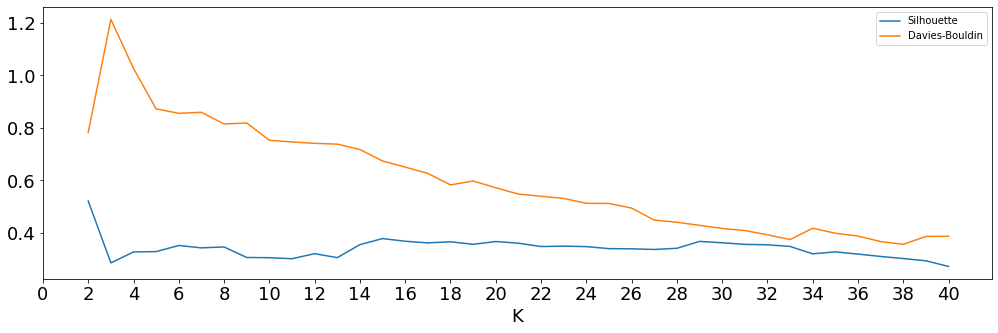

In [55]:
plot_metrics_per_k(X_pca_wo_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="complete"))

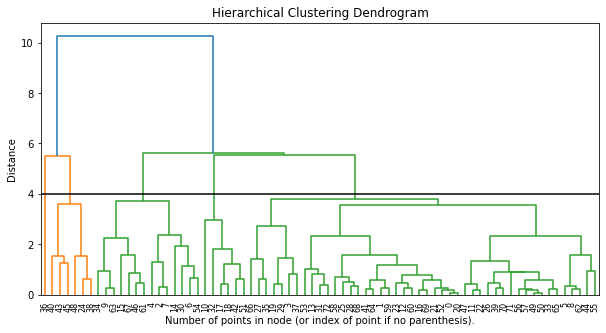

Current number of clusters: 5
Number of points per cluster label: {0: 46, 1: 6, 2: 14, 3: 6, 4: 1}
Number of singleton clusters: 1
Silhouette score: 0.2694968523990688


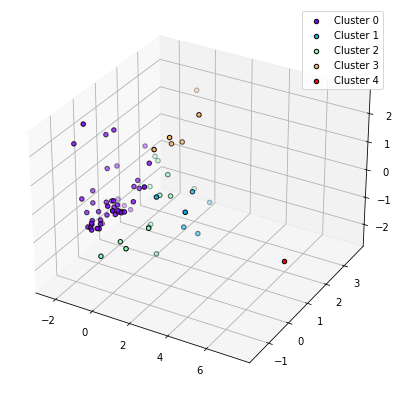

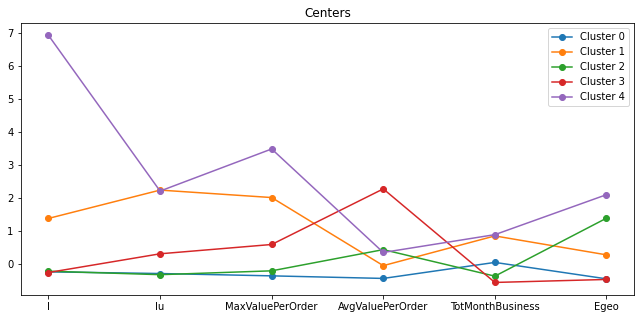

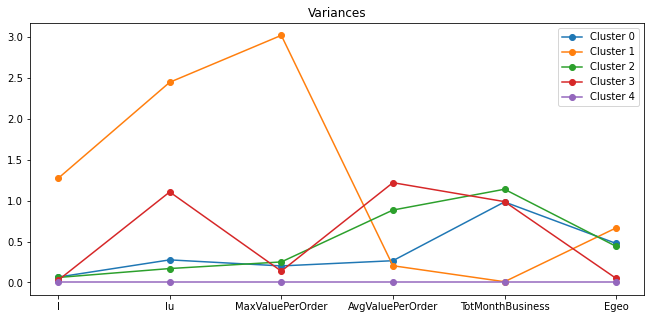

Cophenetic coefficient: 0.7712574928744994


In [56]:
max_d = 4#2.5

hier_clustering_complete_wo_out_pca = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="complete").fit(X_pca_wo_out)

plot_dendrogram(hier_clustering_complete_wo_out_pca, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_wo_out], [hier_clustering_complete_wo_out_pca], [vendor_df_wo_out_vis])

Z = linkage(X_wo_out, 'complete')
c, coph_dists = cophenet(Z, pdist(X_wo_out))
print(f"Cophenetic coefficient: {c}")

#### Conclusion  
Using the Complete linkage were much more similar to what we found out with kmeans, further confirming the findings.  
The PCA version of the analysis with this algorithm was particularly different: the version with outliers produced worse results than the non-PCA version, while the version without outliers produced a good result, about on par with Kmeans. 

### Average linkage with outliers

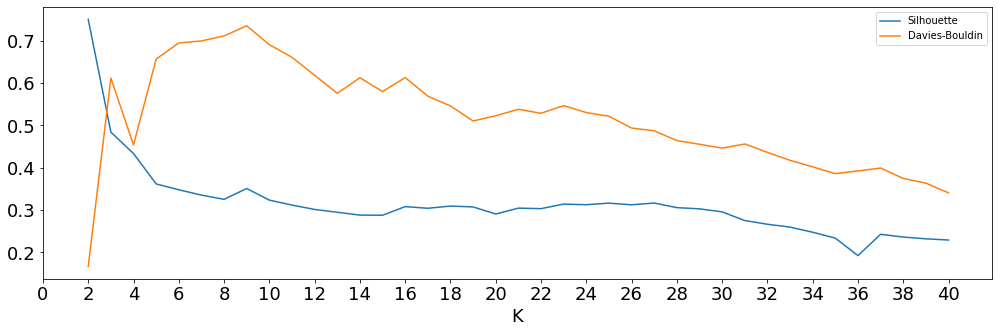

In [57]:
plot_metrics_per_k(X_w_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="average"))

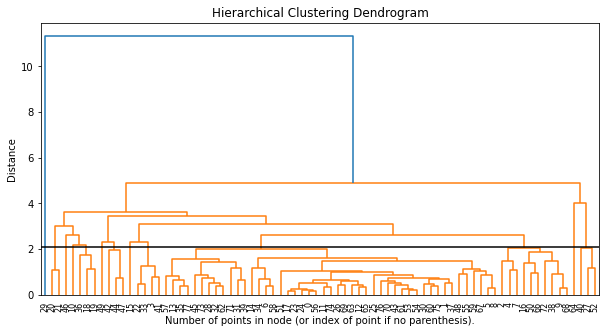

Current number of clusters: 13
Number of points per cluster label: {0: 10, 1: 47, 2: 3, 3: 3, 4: 1, 5: 3, 6: 4, 7: 1, 8: 2, 9: 1, 10: 1, 11: 1, 12: 1}
Number of singleton clusters: 6
Silhouette score: 0.2948664041407814


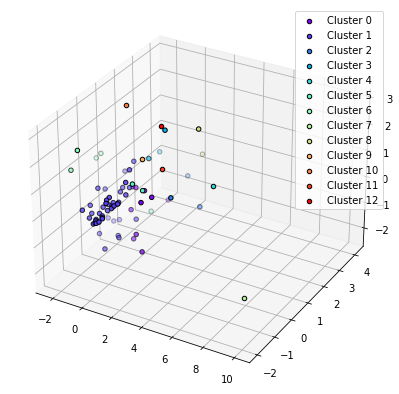

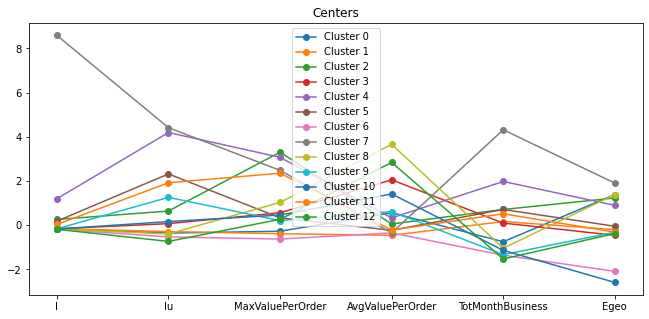

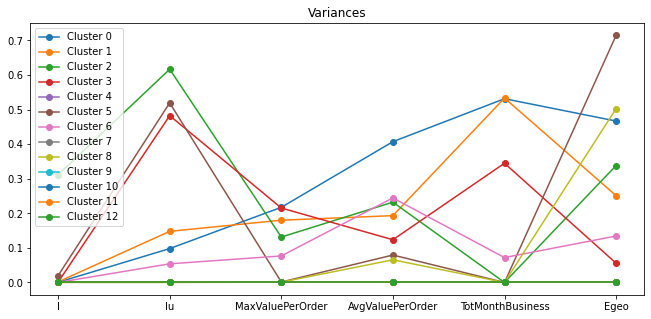

Cophenetic coefficient: 0.9265228995818682


In [58]:
max_d = 2.1

hier_clustering_avg_w_out = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="average").fit(X_w_out)

plot_dendrogram(hier_clustering_avg_w_out, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_w_out], [hier_clustering_avg_w_out], [vendor_df_w_out_vis])

Z = linkage(X_w_out, 'average')
c, coph_dists = cophenet(Z, pdist(X_w_out))
print(f"Cophenetic coefficient: {c}")

### Average linkage without outliers

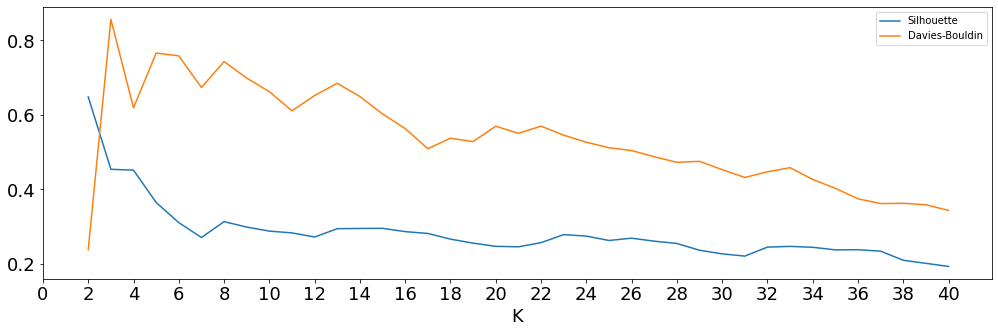

In [59]:
plot_metrics_per_k(X_wo_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="average"))

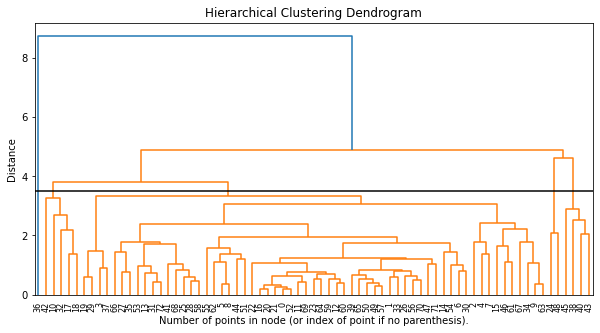

Current number of clusters: 5
Number of points per cluster label: {0: 61, 1: 5, 2: 4, 3: 1, 4: 2}
Number of singleton clusters: 1
Silhouette score: 0.3647662227485973


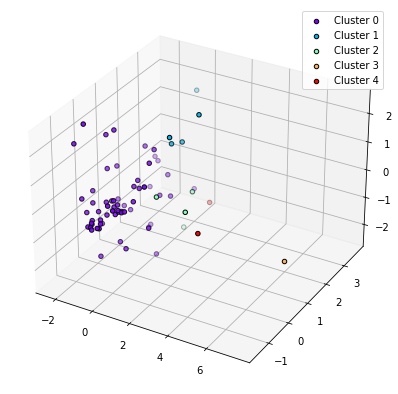

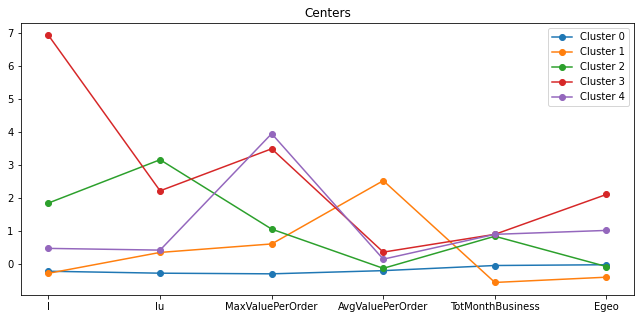

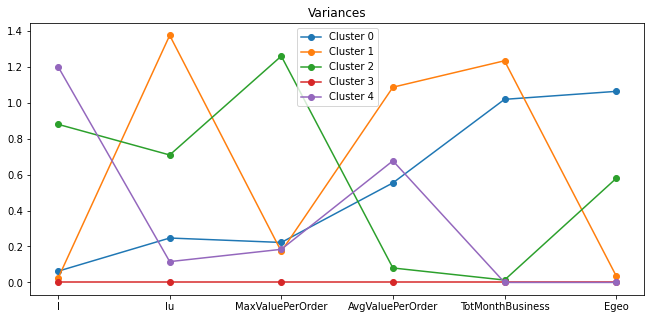

Cophenetic coefficient: 0.9097612119172439


In [60]:
max_d = 3.5

hier_clustering_avg_wo_out = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="average").fit(X_wo_out)

plot_dendrogram(hier_clustering_avg_wo_out, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_wo_out], [hier_clustering_avg_wo_out], [vendor_df_wo_out_vis])

Z = linkage(X_wo_out, 'average')
c, coph_dists = cophenet(Z, pdist(X_wo_out))
print(f"Cophenetic coefficient: {c}")

### Average linkage with outliers (PCA)

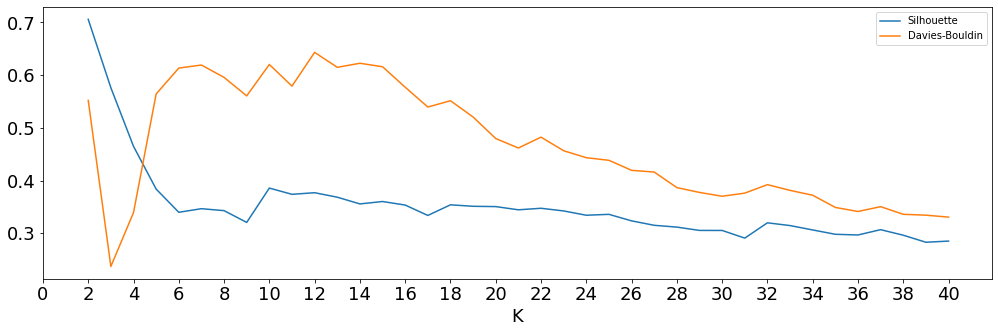

In [61]:
plot_metrics_per_k(X_pca_w_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="average"))

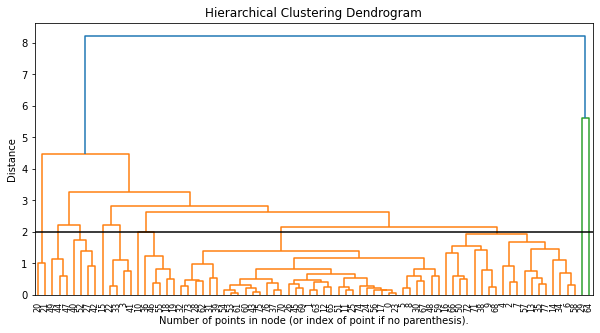

Current number of clusters: 10
Number of points per cluster label: {0: 6, 1: 37, 2: 19, 3: 4, 4: 3, 5: 1, 6: 4, 7: 1, 8: 1, 9: 2}
Number of singleton clusters: 3
Silhouette score: 0.32360320177983865


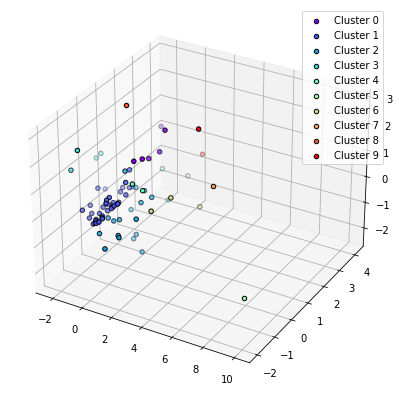

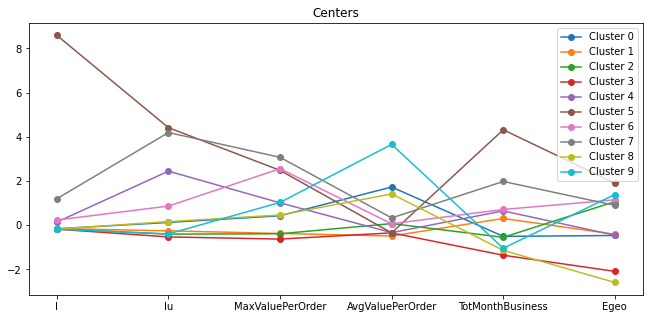

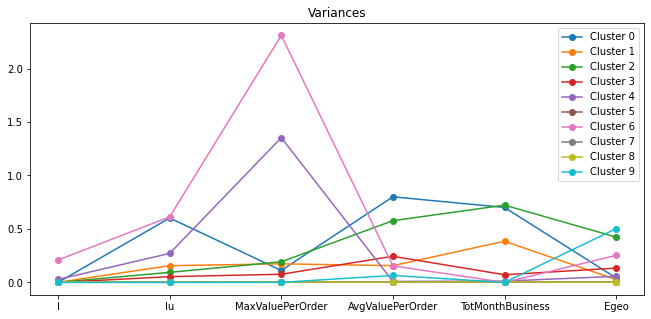

Cophenetic coefficient: 0.8799819691286043


In [62]:
max_d = 2

hier_clustering_avg_w_out_pca = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="average").fit(X_pca_w_out)

plot_dendrogram(hier_clustering_avg_w_out_pca, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_w_out], [hier_clustering_avg_w_out_pca], [vendor_df_w_out_vis])

Z = linkage(X_pca_w_out, 'average')
c, coph_dists = cophenet(Z, pdist(X_pca_w_out))
print(f"Cophenetic coefficient: {c}")

### Average linkage without outliers (PCA)

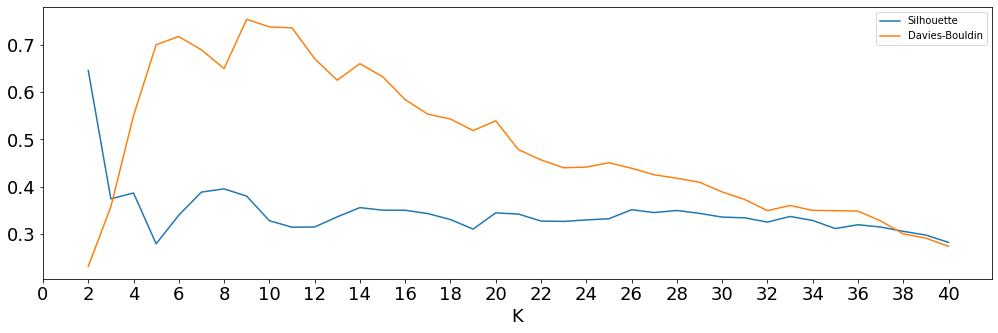

In [63]:
plot_metrics_per_k(X_pca_wo_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="average"))

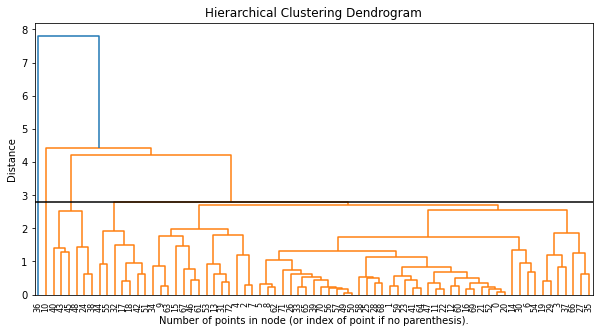

Current number of clusters: 5
Number of points per cluster label: {0: 58, 1: 6, 2: 1, 3: 1, 4: 7}
Number of singleton clusters: 2
Silhouette score: 0.2408125740229113


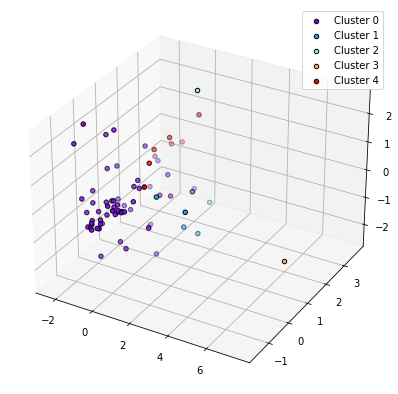

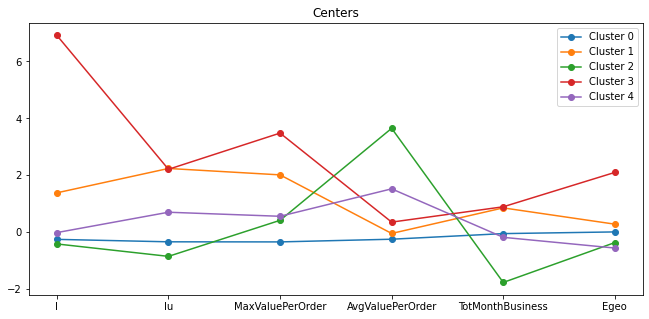

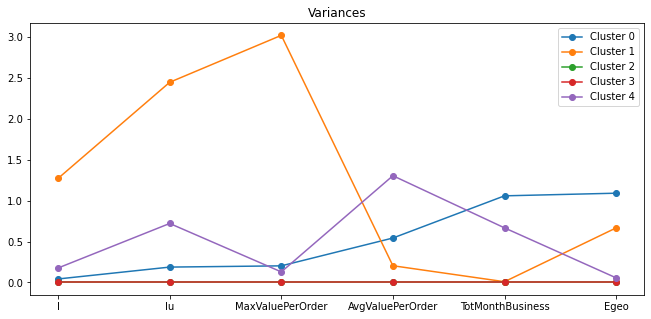

Cophenetic coefficient: 0.8804754958042802


In [64]:
max_d = 2.8

hier_clustering_avg_wo_out_pca = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="average").fit(X_pca_wo_out)

plot_dendrogram(hier_clustering_avg_wo_out_pca, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_wo_out], [hier_clustering_avg_wo_out_pca], [vendor_df_wo_out_vis])

Z = linkage(X_pca_wo_out, 'average')
c, coph_dists = cophenet(Z, pdist(X_pca_wo_out))
print(f"Cophenetic coefficient: {c}")

#### Conclusion  
While the non-PCA version provided terrible results, the PCA results are again really close to the current benchmark that is Kmeans.

### Ward method with outliers

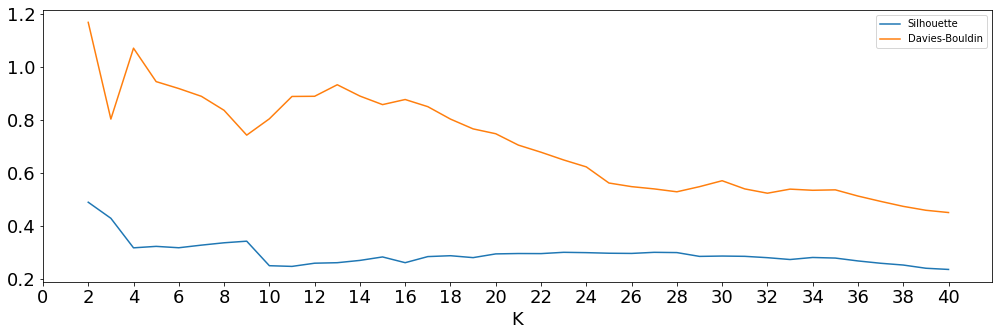

In [65]:
plot_metrics_per_k(X_w_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="ward"))

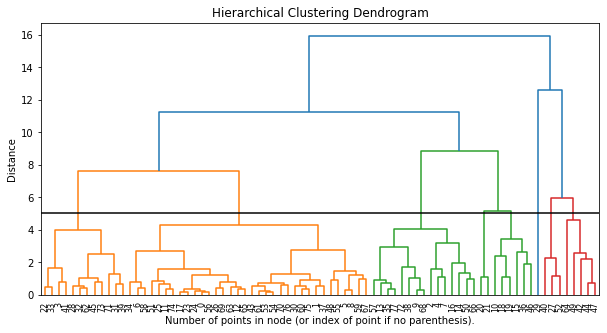

Current number of clusters: 8
Number of points per cluster label: {0: 5, 1: 34, 2: 12, 3: 6, 4: 15, 5: 1, 6: 3, 7: 2}
Number of singleton clusters: 1
Silhouette score: 0.33553260768309673


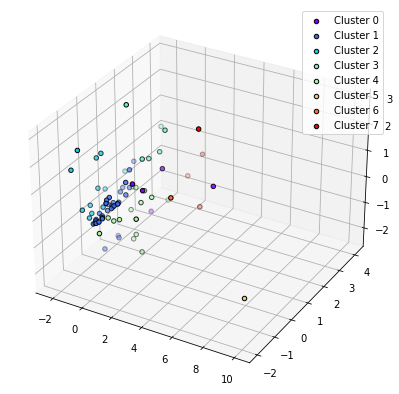

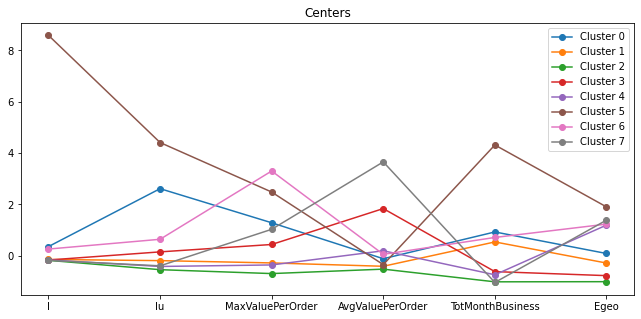

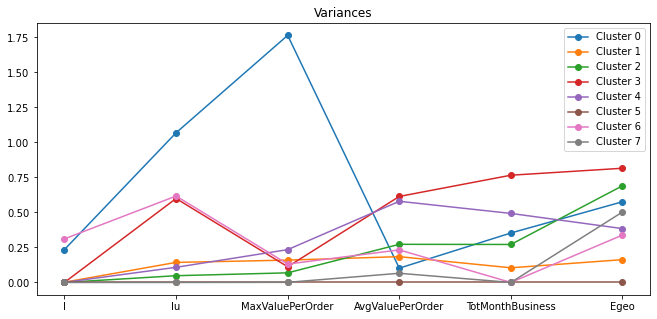

Cophenetic coefficient: 0.6556618880140798


In [66]:
max_d = 5

hier_clustering_ward_w_out = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="ward").fit(X_w_out)

plot_dendrogram(hier_clustering_ward_w_out, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_w_out], [hier_clustering_ward_w_out], [vendor_df_w_out_vis])

Z = linkage(X_w_out, 'ward')
c, coph_dists = cophenet(Z, pdist(X_w_out))
print(f"Cophenetic coefficient: {c}")

### Ward method without outliers

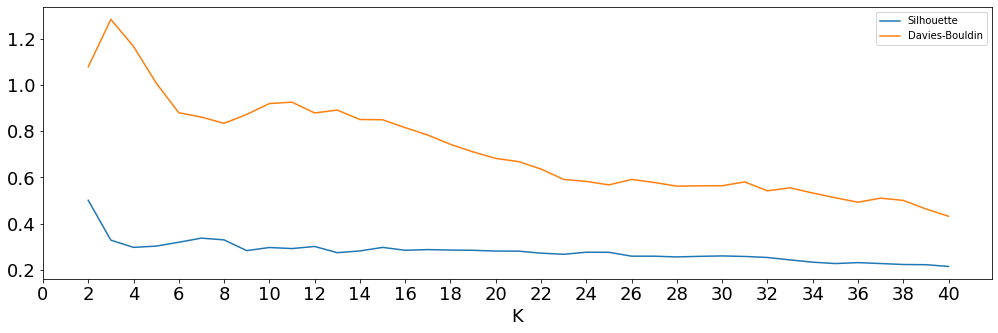

In [67]:
plot_metrics_per_k(X_wo_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="ward"))

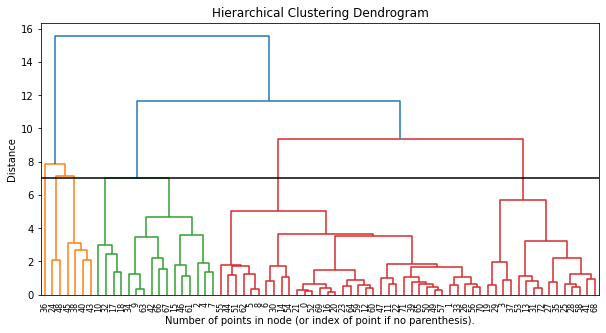

Current number of clusters: 7
Number of points per cluster label: {0: 15, 1: 35, 2: 4, 3: 12, 4: 1, 5: 2, 6: 4}
Number of singleton clusters: 1
Silhouette score: 0.33698722328354325


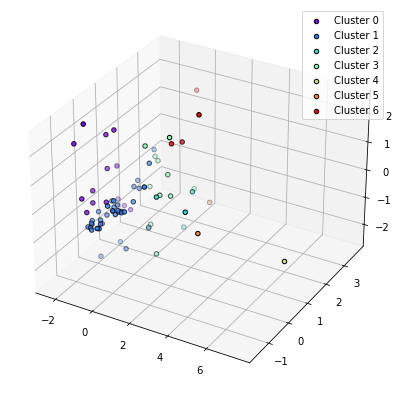

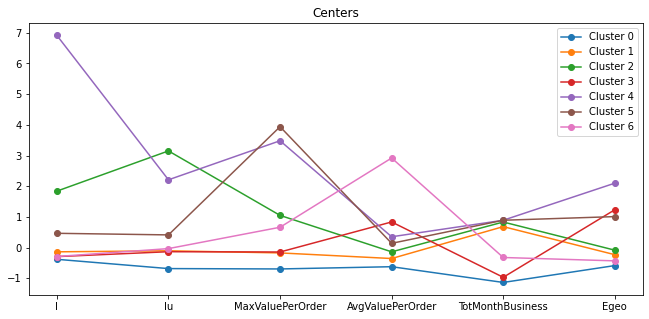

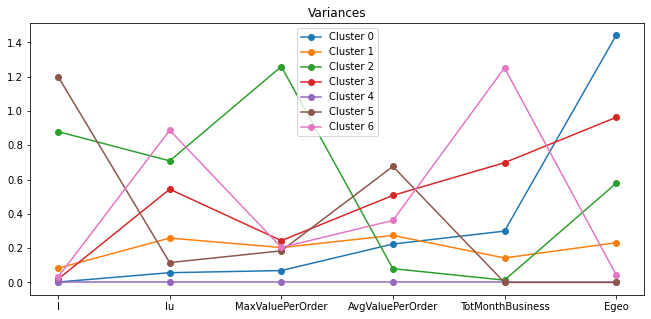

Cophenetic coefficient: 0.762629331919629


In [68]:
max_d = 7

hier_clustering_ward_wo_out = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="ward").fit(X_wo_out)

plot_dendrogram(hier_clustering_ward_wo_out, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_wo_out], [hier_clustering_ward_wo_out], [vendor_df_wo_out_vis])

Z = linkage(X_wo_out, 'ward')
c, coph_dists = cophenet(Z, pdist(X_wo_out))
print(f"Cophenetic coefficient: {c}")

### Ward method with outliers (PCA)

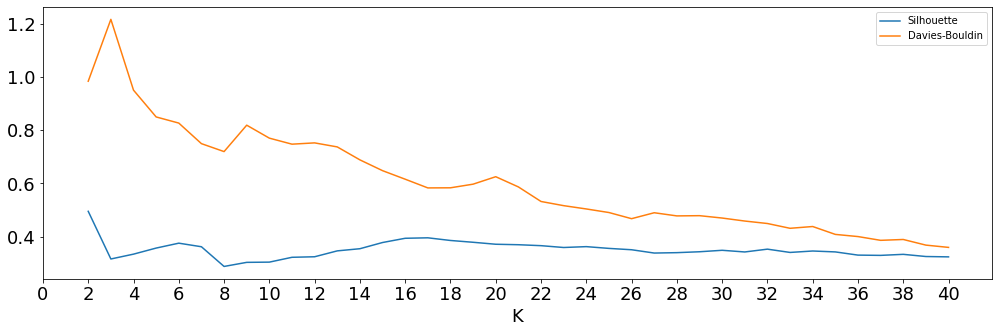

In [69]:
plot_metrics_per_k(X_pca_w_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="ward"))

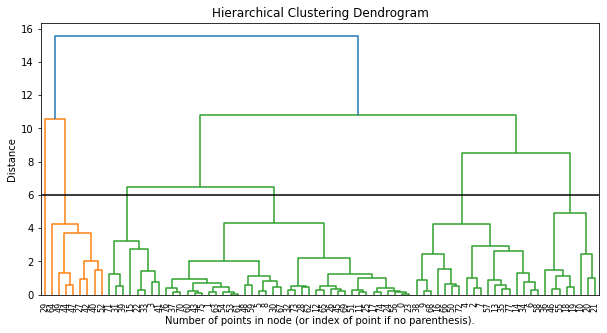

Current number of clusters: 6
Number of points per cluster label: {0: 8, 1: 18, 2: 35, 3: 1, 4: 8, 5: 8}
Number of singleton clusters: 1
Silhouette score: 0.3318822504843945


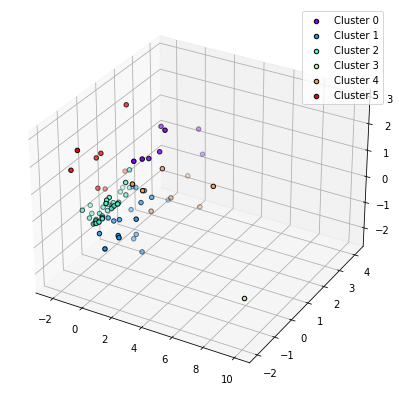

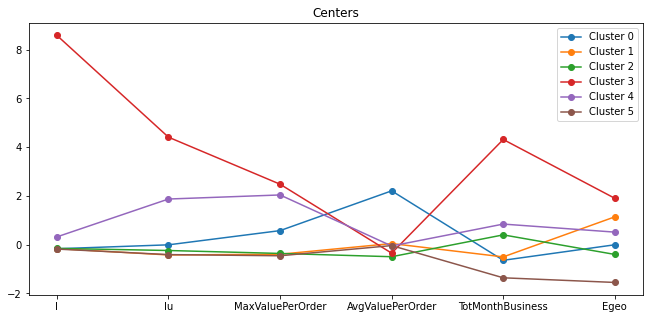

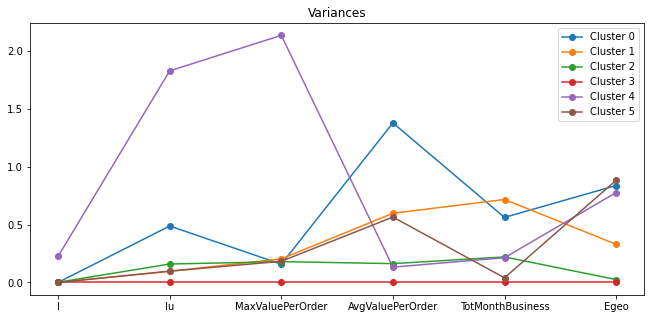

Cophenetic coefficient: 0.6132723614088502


In [70]:
max_d = 6

hier_clustering_ward_w_out_pca = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="ward").fit(X_pca_w_out)

plot_dendrogram(hier_clustering_ward_w_out_pca, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_w_out], [hier_clustering_ward_w_out_pca], [vendor_df_w_out_vis])

Z = linkage(X_pca_w_out, 'ward')
c, coph_dists = cophenet(Z, pdist(X_pca_w_out))
print(f"Cophenetic coefficient: {c}")

### Ward method without outliers (PCA)

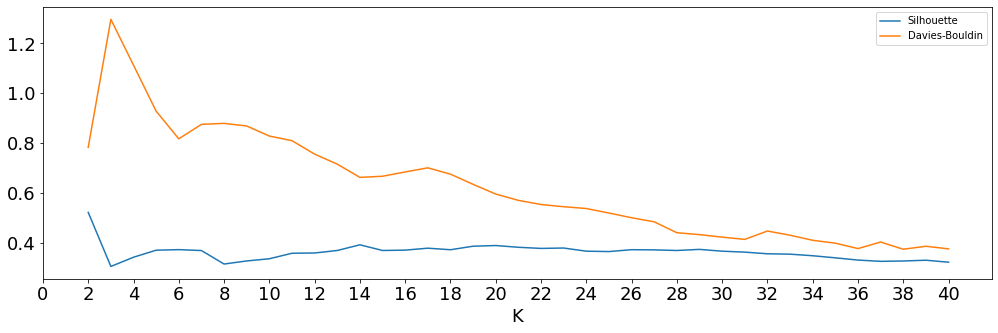

In [71]:
plot_metrics_per_k(X_pca_wo_out, ["sil", "db"], model_sk=AgglomerativeClustering(compute_distances=True, n_clusters=1, linkage="ward"))

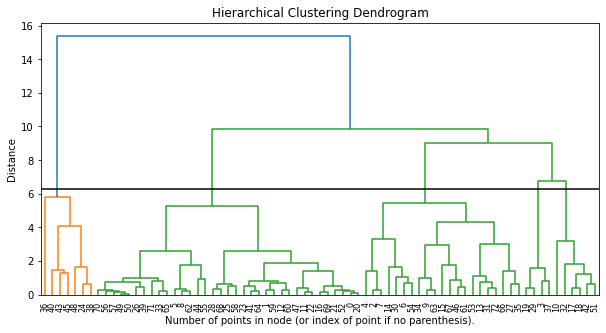

Current number of clusters: 5
Number of points per cluster label: {0: 7, 1: 21, 2: 35, 3: 6, 4: 4}
Number of singleton clusters: 0
Silhouette score: 0.3071821586862541


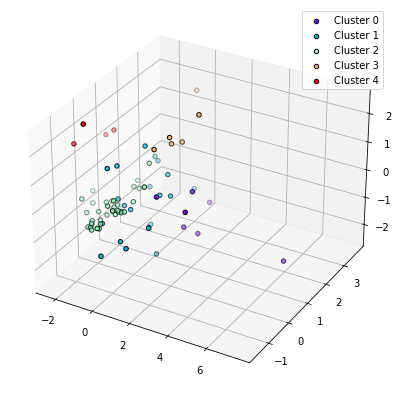

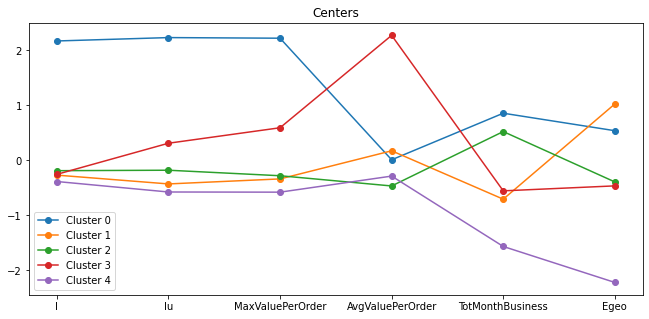

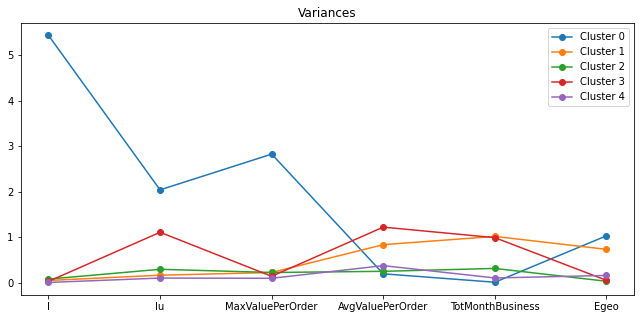

Cophenetic coefficient: 0.7401721365455793


In [72]:
max_d = 6.3

hier_clustering_ward_wo_out_pca = AgglomerativeClustering(distance_threshold=max_d, n_clusters=None, linkage="ward").fit(X_pca_wo_out)

plot_dendrogram(hier_clustering_ward_wo_out_pca, max_d, truncate_mode='level', p=20)
visualise_model_characteristics([X_wo_out], [hier_clustering_ward_wo_out_pca], [vendor_df_wo_out_vis])

Z = linkage(X_pca_wo_out, 'ward')
c, coph_dists = cophenet(Z, pdist(X_pca_wo_out))
print(f"Cophenetic coefficient: {c}")

#### Conclusion  
The results are practically identical to Kmeans, this is mostly given to the fact that both methods try to minimise the global SSE of the clustering.

### Dendogram comparisons

## Clustering conclusions

In [73]:
def construct_clust_df(clust_dict):
    
    out_df = pd.DataFrame(columns=["Type", "Clusters", "Silhouette", "Davies-Bouldin", "Ideal corr"])
    
    for key in clust_dict:
        k = len(np.unique(clust_dict[key][0].labels_))

        sil_score = silhouette_score(clust_dict[key][1], clust_dict[key][0].labels_)
        db_score = davies_bouldin_score(clust_dict[key][1], clust_dict[key][0].labels_)
        id_corr_avg = np.mean(compute_ideal_similarity_coeff(clust_dict[key][1], clust_dict[key][0].labels_))

        entry_series = pd.Series({"Type":key, "Clusters":k, "Silhouette":sil_score, "Davies-Bouldin": db_score,
                                  "Ideal corr":id_corr_avg})
        out_df = out_df.append(entry_series, ignore_index=True)
        
    return out_df

In [74]:
kmeans_dict = {"K-means with outliers":(kmeans_w_out, X_w_out), 
               "K-means without outliers":(kmeans_wo_out, X_wo_out), 
               "K-means with outliers (Ward)":(kmeans_w_out_ward, X_w_out),
               "K-means without outliers (Ward)":(kmeans_wo_out_ward, X_wo_out)}

xmeans_dict = {"X-means with outliers":(xmeans_w_out, X_w_out), 
               "X-means without outliers":(xmeans_wo_out, X_wo_out), 
               "X-means with outliers (Ward)":(xmeans_w_out_ward, X_w_out), 
               "X-means without outliers (Ward)":(xmeans_wo_out_ward, X_wo_out)}

density_dict = {"DBSCAN with outliers":(dbscan_w_out, X_w_out), 
                "DBSCAN without outliers":(dbscan_wo_out, X_wo_out), 
                "DBSCAN with outliers (PCA)":(dbscan_w_out_pca, X_pca_w_out), 
                "DBSCAN without outliers (PCA)":(dbscan_wo_out_pca, X_pca_wo_out)}

hier_dict = {"Single with outliers":(hier_clustering_single_w_out, X_w_out, "single"), 
             "Single without outliers":(hier_clustering_single_wo_out, X_wo_out, "single"), 
             "Single with outliers (PCA)":(hier_clustering_single_w_out_pca, X_pca_w_out, "single"), 
             "Single without outliers (PCA)":(hier_clustering_single_wo_out_pca, X_pca_wo_out, "single"),
             "Complete with outliers":(hier_clustering_complete_w_out, X_w_out, "complete"), 
             "Complete without outliers":(hier_clustering_complete_wo_out, X_wo_out, "complete"), 
             "Complete with outliers (PCA)":(hier_clustering_complete_w_out_pca, X_pca_w_out, "complete"), 
             "Complete without outliers (PCA)":(hier_clustering_complete_wo_out_pca, X_pca_wo_out, "complete"), 
             "Average with outliers":(hier_clustering_avg_w_out, X_w_out, "average"), 
             "Average without outliers":(hier_clustering_avg_wo_out, X_wo_out, "average"), 
             "Average with outliers (PCA)":(hier_clustering_avg_w_out_pca, X_pca_w_out, "average"),
             "Average without outliers (PCA)":(hier_clustering_avg_wo_out_pca, X_pca_wo_out, "average"), 
             "Ward with outliers":(hier_clustering_ward_w_out, X_w_out, "ward"), 
             "Ward without outliers":(hier_clustering_ward_wo_out, X_wo_out, "ward"), 
             "Ward with outliers (PCA)":(hier_clustering_ward_w_out_pca, X_pca_w_out, "ward"), 
             "Ward without outliers (PCA)":(hier_clustering_ward_wo_out_pca, X_pca_wo_out, "ward")}

In [75]:
best_clust_dict_w_out = {"K-means with outliers (Ward)":(kmeans_w_out_ward, X_w_out),
    "Average with outliers (PCA)":(hier_clustering_avg_w_out_pca, X_pca_w_out, "average"),
    "Complete with outliers":(hier_clustering_complete_w_out, X_w_out, "complete"), 
    "Complete with outliers (PCA)":(hier_clustering_complete_w_out_pca, X_pca_w_out, "complete"), 
    "Ward with outliers":(hier_clustering_ward_w_out, X_w_out, "ward"), 
    "Ward with outliers (PCA)":(hier_clustering_ward_w_out_pca, X_pca_w_out, "ward")}

best_clust_dict_wo_out = {"K-means without outliers (Ward)":(kmeans_wo_out_ward, X_wo_out),
    "Average without outliers (PCA)":(hier_clustering_avg_wo_out_pca, X_pca_wo_out, "average"),
    "Complete without outliers":(hier_clustering_complete_wo_out, X_wo_out, "complete"),
    "Complete without outliers (PCA)":(hier_clustering_complete_wo_out_pca, X_pca_wo_out, "complete"),
    "Ward without outliers":(hier_clustering_ward_wo_out, X_wo_out, "ward"),
    "Ward without outliers (PCA)":(hier_clustering_ward_wo_out_pca, X_pca_wo_out, "ward")}

best_clust_df_w_out = construct_clust_df(best_clust_dict_w_out)
best_clust_df_wo_out = construct_clust_df(best_clust_dict_wo_out)

In [76]:
best_clust_df_w_out.sort_values("Silhouette", ascending=False)

Type Clusters  Silhouette  Davies-Bouldin  \
1   Average with outliers (PCA)       10    0.385718        0.620174   
5      Ward with outliers (PCA)        6    0.375078        0.827062   
3  Complete with outliers (PCA)        9    0.374820        0.650071   
4            Ward with outliers        8    0.335533        0.836159   
0  K-means with outliers (Ward)        4    0.326344        1.004382   
2        Complete with outliers        6    0.316963        0.920156   

   Ideal corr  
1    0.780375  
5    0.772885  
3    0.780517  
4    0.787012  
0    0.772379  
2    0.784167

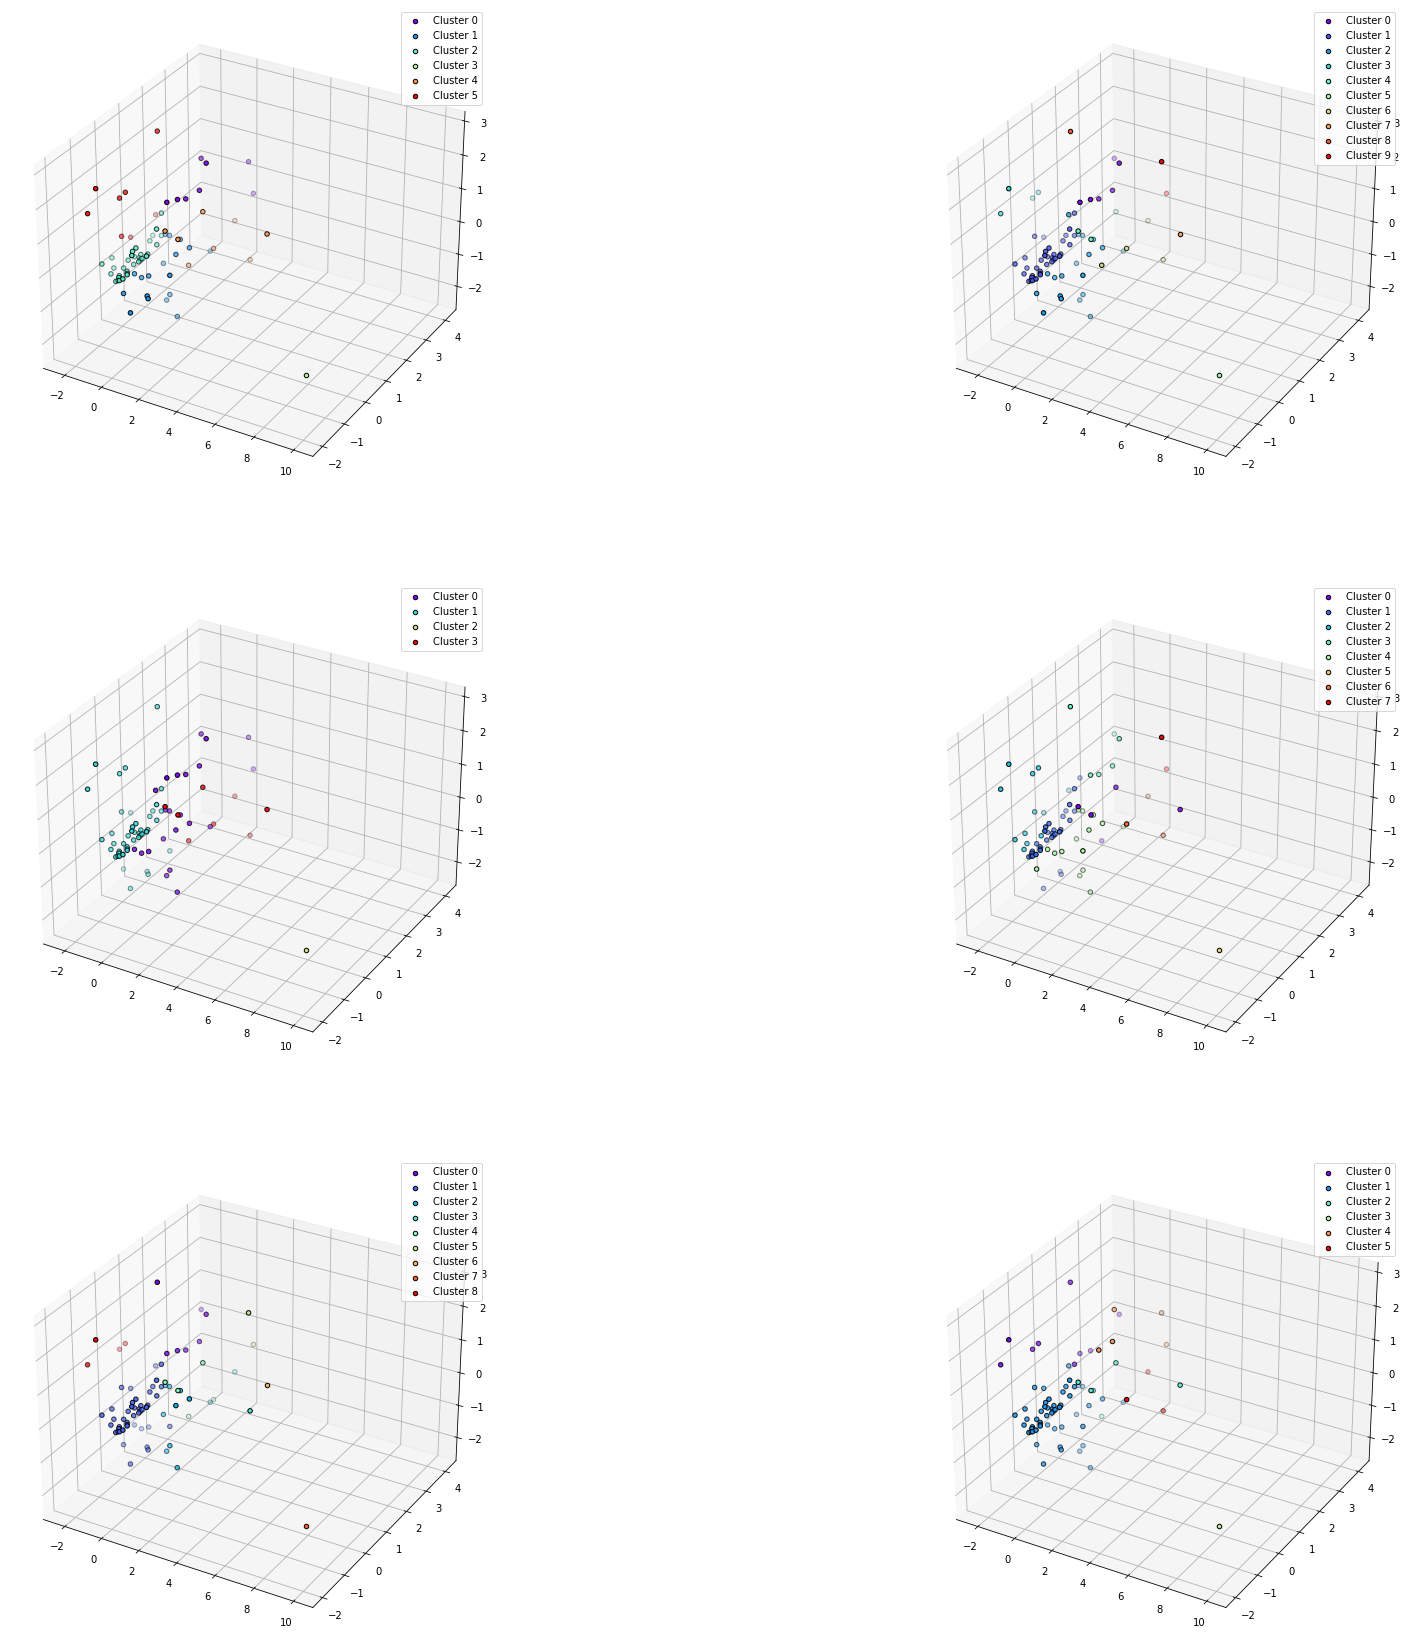

In [77]:
plot_3d_scatter([vendor_df_w_out_vis, vendor_df_w_out_vis, vendor_df_w_out_vis, vendor_df_w_out_vis, vendor_df_w_out_vis, vendor_df_w_out_vis], 
                [hier_clustering_ward_w_out_pca.labels_, hier_clustering_avg_w_out_pca.labels_, 
                kmeans_w_out_ward.labels_, hier_clustering_ward_w_out.labels_, hier_clustering_complete_w_out_pca.labels_, 
                hier_clustering_complete_w_out.labels_])

Apart from the last two, the other results are pretty much identical.

In [78]:
best_clust_df_wo_out.sort_values("Silhouette", ascending=False)

Type Clusters  Silhouette  Davies-Bouldin  \
5      Ward without outliers (PCA)        5    0.369414        0.927923   
4            Ward without outliers        7    0.336987        0.860720   
3  Complete without outliers (PCA)        5    0.328792        0.872220   
1   Average without outliers (PCA)        5    0.279082        0.700148   
2        Complete without outliers        8    0.236511        0.899064   
0  K-means without outliers (Ward)        7    0.211715        1.198402   

   Ideal corr  
5    0.639951  
4    0.716736  
3    0.672623  
1    0.666560  
2    0.719183  
0    0.679181

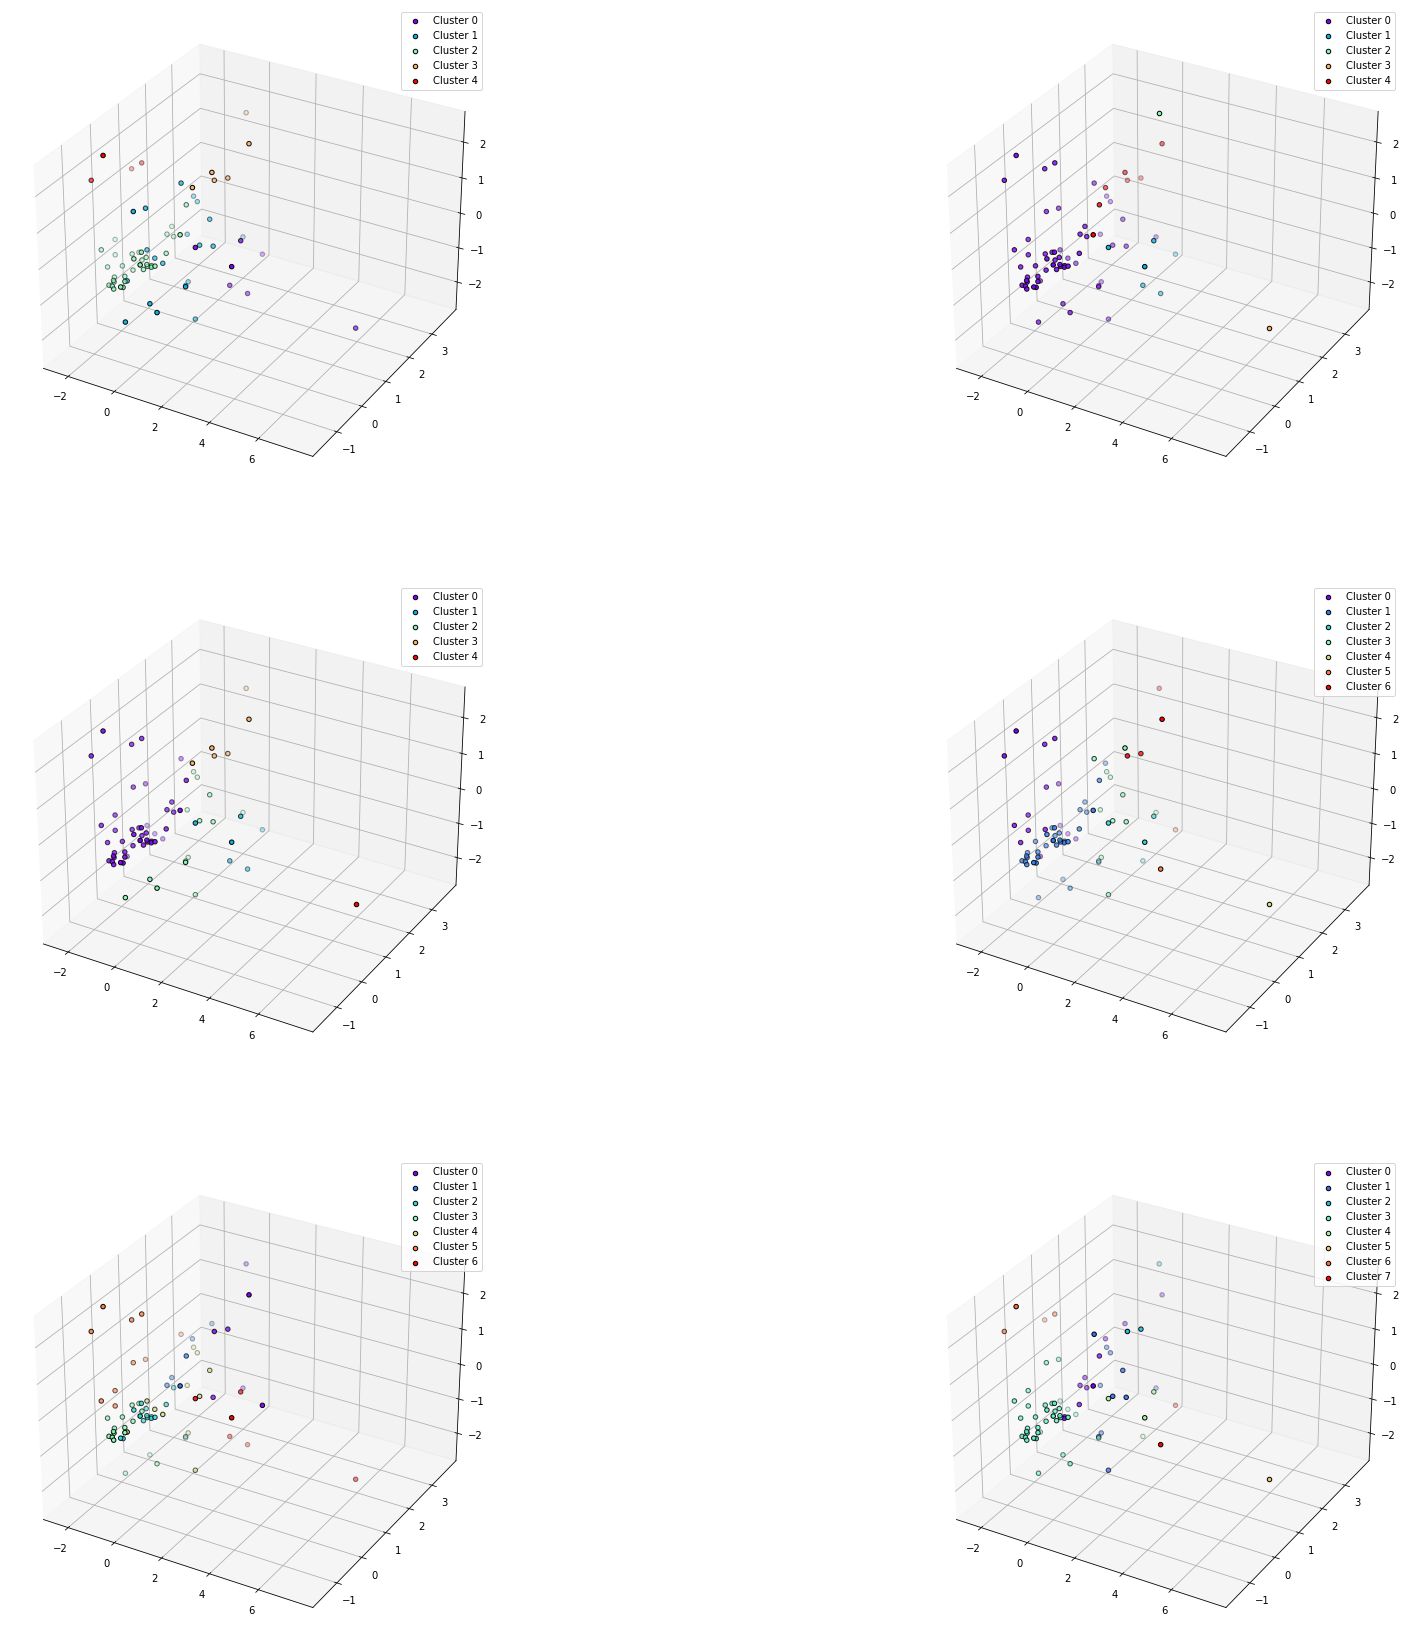

In [79]:
plot_3d_scatter([vendor_df_wo_out_vis, vendor_df_wo_out_vis, vendor_df_wo_out_vis, vendor_df_wo_out_vis, vendor_df_wo_out_vis, vendor_df_wo_out_vis], 
                [hier_clustering_ward_wo_out_pca.labels_, hier_clustering_avg_wo_out_pca.labels_, hier_clustering_complete_wo_out_pca.labels_,
                hier_clustering_ward_wo_out.labels_, kmeans_wo_out_ward.labels_, hier_clustering_complete_wo_out.labels_])

Same as above.

# TODO  
Write dendogram paragraph  
Cluster visual evaluation matrix
Clean-up and comment code